## Outline
1. Load Libraries
2. Functions
    * 2.1 Intensity and Sleep Plots
    * 2.2 Retrieve Sleep Data
    * 2.3 Retrieve Activity Data
    * 2.4 Prophet Prediction
    * 2.5 Prophet Prediction Plot
    * 2.6 Prophet Component Plot
3. Data Retrieval
    * 3.1 CSV import loop
    * 3.2 Dataframe Retrieval and merge
4. Visualizations
    * 4.1 Activity data timeseries trend
    * 4.2 Activity data Prophet prediction
    * 4.3 Sleep vs. Activity scatter plot and histograms for all data
    * 4.4 Sleep vs. Activity scatter plots by user Id
    * 4.5 Python Panel interactive data exploration tool
5.  Extra Code
    * Extra code can be found in the q2_sleep_impact_full.ipynb notebook under the "More Code" Section.
        - outlier analysis
        - manual activity data retrieval
        - manual sleep data retrieval
        - sleep data pull using user input
        - merge code
        - manual plotting
        - manual plotting using gridspec
        - previous python panel version 


## 1.  Load Libraries

In [197]:
#load libraries
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import os as os
import panel as pn
import math

pn.extension()

## 2.  Functions

In [198]:
#2.1 intensity and sleep comparison
def intensity_sleep_plots(data, sleep_level="all",user_id="all",activity_level="all"):
    #variables
    x_tick_fs=10
    y_tick_fs=10
    x_label_fs=12
    y_label_fs=12
    title_fs=14
    max_x=data["sleep_minutes"].max()
    max_y=data["intensity_minutes"].max()
    x_interval=math.ceil(max_x/20)
    y_interval=math.ceil(max_y/20)
    min_x=0-x_interval
    min_y=0-y_interval

    #corelation coefficient
    cor_matrix=data[["intensity_minutes","sleep_minutes"]].corr()
    cor_coef=round(cor_matrix.loc["intensity_minutes","sleep_minutes"],4)

    #level descriptions
    match sleep_level:
        case("all"):
            desc_sleep_level="All Sleep Levels"
        case(1):
            desc_sleep_level="Light Sleep Only"
        case(2):
            desc_sleep_level="Deep Sleep Only"
        case(3):
            desc_sleep_level="REM Sleep Only"

    match user_id:
        case("all"):
            desc_user_id="All Users"
        case _:
            desc_user_id=str(user_id)

    match activity_level:
        case("all"):
            desc_activity_level="All Activity Levels"
        case(1):
            desc_activity_level="Light Activity Only"
        case(2):
            desc_activity_level="Moderate Activity Only"
        case(3):
            desc_activity_level="Vigorous Activity Only"

    #scatter plot
    fig1, ax1 = plt.subplots(figsize=(7,6))
    ax1.scatter(x=data["sleep_minutes"], y=data["intensity_minutes"])
    ax1.set_yticks(ticks=range(min_y,max_y+y_interval,y_interval))
    ax1.tick_params(axis="y", labelsize=y_tick_fs)
    ax1.set_ylim(min_y,max_y+y_interval)
    ax1.set_xticks(ticks=range(min_x,max_x+x_interval,x_interval))
    ax1.set_xlim(min_x,max_x+x_interval)
    ax1.tick_params(axis="x", labelsize=x_tick_fs,rotation=90)
    ax1.set_xlabel("Amount of Sleep (min)",fontweight="bold",fontsize=x_label_fs)
    ax1.set_ylabel("Amount of Activity (min)",fontweight="bold",fontsize=y_label_fs)
    ax1.set_title(f"Amount of Sleep vs. Amount of Activity\n {desc_sleep_level}, {desc_user_id}, {desc_activity_level}",fontweight="bold",fontsize=title_fs)
    ax1.annotate(f"Corr Coef: {cor_coef}",xy=(0.65,0.9),xycoords="axes fraction", color="red",fontsize=12, fontweight="bold")
    plt.close() 

    #plot histogram of sleep
    fig2, ax1 = plt.subplots(figsize=(7,6))
    n, bins, patches=ax1.hist(data["sleep_minutes"],bins=25)
    ax1.set_xlim(min_x,max_x+x_interval)
    ax1.set_xticks(ticks=range(min_x,max_x+x_interval,math.ceil((max_x+x_interval)/25)))
    ax1.set_xlabel("Amount of Sleep Bin",fontweight="bold",fontsize=x_label_fs)
    ax1.tick_params(axis="x", rotation=90,labelsize=x_tick_fs)
    ax1.set_ylim(0,int(n.max())+math.ceil((int(n.max())/20)))
    ax1.set_yticks(ticks=range(0,int(n.max())+math.ceil((int(n.max())/20)),math.ceil(int(n.max())/20)))
    ax1.set_ylabel("Count",fontweight="bold",fontsize=y_label_fs)
    ax1.tick_params(axis="y",labelsize=y_tick_fs)
    ax1.set_title(f"Histogram of Amount of Sleep\n{desc_sleep_level}, {desc_user_id}, {desc_activity_level}", fontweight="bold",fontsize=title_fs)
    plt.close() 

    #plot histogram of activity
    fig3, ax1 = plt.subplots(figsize=(7,6))
    n, bins, patches=ax1.hist(data["intensity_minutes"],bins=25)
    ax1.set_xlim(min_y,min_y+y_interval)
    ax1.set_xticks(ticks=range(min_y,max_y+y_interval,math.ceil((max_y+y_interval)/25)))
    ax1.set_xlabel("Amount of Activity Bin",fontweight="bold",fontsize=x_label_fs)
    ax1.tick_params(axis="x", rotation=90,labelsize=x_tick_fs)
    ax1.set_ylim(0,int(n.max())+math.ceil((int(n.max())/20)))
    ax1.set_yticks(ticks=range(0,int(n.max())+math.ceil((int(n.max())/20)),math.ceil(int(n.max())/20)))
    ax1.set_ylabel("Count",fontweight="bold", fontsize=y_label_fs)
    ax1.tick_params(axis="y",labelsize=y_tick_fs)
    ax1.set_title(f"Histogram of Amount of Activity\n{desc_sleep_level}, {desc_user_id}, {desc_activity_level}", fontweight="bold",fontsize=title_fs)
    plt.close() 

    
    return([fig1,fig2,fig3,desc_sleep_level,desc_user_id,desc_activity_level])

In [199]:
#2.2 get sleep data

def get_sleep_data(sleep_level, user_id):
    #load the dataframe
    df_sleep_minute=dataframes_dict['minuteSleep_merged'].copy()

    #convert date to date time, extract the date
    df_sleep_minute["date"]=pd.to_datetime(df_sleep_minute["date"],format='%m/%d/%Y %I:%M:%S %p')
    df_sleep_minute["date2"]=df_sleep_minute["date"].dt.strftime('%Y-%m-%d')

    #filter to sleep level and user_id
    #convert inputs to int
    match (str(sleep_level).lower(), str(user_id).lower()):
        case("all","all"):
            pass #no filtering taking place
        case(_,"all"):
            sleep_level=int(sleep_level)
            df_sleep_minute=df_sleep_minute[(df_sleep_minute["value"]==sleep_level)]
        case("all",_):
            user_id=int(user_id)
            df_sleep_minute=df_sleep_minute[(df_sleep_minute["Id"]==user_id)]
        case _:
            sleep_level=int(sleep_level)
            user_id=int(user_id)
            df_sleep_minute=df_sleep_minute[(df_sleep_minute["value"]==sleep_level) & (df_sleep_minute["Id"]==user_id)]


    #remove duplicates (some of the 4/12 data is in both files)
    df_sleep_minute=df_sleep_minute.drop_duplicates()

    #find max date because logId spans midnight
    df_max_date_logid=df_sleep_minute.groupby(by=["logId"]).agg(
    max_date=("date2","max")).reset_index()

    #merge in max date with sleep data
    df_sleep_minute=pd.merge(df_sleep_minute,df_max_date_logid,
                             how="left",
                             on="logId")

    #group and aggregate
    df_sleep_day=df_sleep_minute.groupby(by=["Id","logId"]).agg(
        sleep_minutes=("value","count"),
        date=("max_date","max")).reset_index()

    #drop logId column amd reorder
    df_sleep_day=df_sleep_day.drop(columns=["logId"])
    df_sleep_day=df_sleep_day[["Id","date","sleep_minutes"]]

    return ([df_sleep_day,sleep_level,user_id])

In [200]:
#2.3 get intensity data
def get_intensity_data(activity_level,user_id):
    #load the dataframe
    df_intensity_minute=dataframes_dict['minuteIntensitiesNarrow_merged'].copy()

    #convert ActivityMinute to date time and extract the date
    df_intensity_minute["ActivityMinute"]=pd.to_datetime(df_intensity_minute["ActivityMinute"],format='%m/%d/%Y %I:%M:%S %p')
    df_intensity_minute["date"]=df_intensity_minute["ActivityMinute"].dt.strftime('%Y-%m-%d')

    #filter to activity level and user id
    #convert inputs to int
    match (str(activity_level).lower(), str(user_id).lower()):
        case("all","all"):
            pass #no filtering taking place
        case(_,"all"):
            activity_level=int(activity_level)
            df_intensity_minute=df_intensity_minute[(df_intensity_minute["Intensity"]==activity_level)]
        case("all",_):
            user_id=int(user_id)
            df_intensity_minute=df_intensity_minute[(df_intensity_minute["Id"]==user_id)]
        case _:
            activity_level=int(activity_level)
            user_id=int(user_id)
            df_intensity_minute=df_intensity_minute[(df_intensity_minute["Intensity"]==activity_level) & (df_intensity_minute["Id"]==user_id)]
    
    #remove duplicates (some of the 4/12 data is in both files)
    df_intensity_minute=df_intensity_minute.drop_duplicates()

    #Remove rows where Intensity is 0 (0 is resting)
    df_intensity_day=df_intensity_minute[df_intensity_minute["Intensity"] !=0]

    #drop the ActivityMinute column and group by Id and date
    df_intensity_day=df_intensity_day.drop(columns=["ActivityMinute"])
    df_intensity_day=df_intensity_day.groupby(by=["Id","date"]).agg   (intensity_minutes=("Intensity","count")).reset_index()

    return([df_intensity_day,activity_level,user_id])


In [201]:
#2.4 prediction function
def make_prediction(period):
    future=model.make_future_dataframe(periods=int(period),freq="D")
    forecast=model.predict(future)
    return(forecast)

In [202]:
#2.5 function for Prophet Prediction Plot
def prediction_plot(forecasted_data):
    #create the Prophet plot
    fig1=model.plot(forecasted_data, figsize=(10,6))
    ax1=fig1.gca() #get current axis from the Prophet plot 
    ax1.set_title("User Activity Tracked with Fitbit")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Activity Minutes")
    ax1.grid(True)
    fig1.tight_layout()
    plt.close() #so don't show the plot while executing function, only when returned
    return(fig1)

In [203]:
#2.6 function for Prophet Component Plot
def component_plot(forecasted_data):
    #Create plot
    fig1=model.plot_components(forecasted_data,figsize=(10,6))
    ax1=fig1.gca()
    ax1.set_title("Prediction Components")
    ax1.set_xlabel("Date")
    ax1.grid=True
    plt.close()
    return(fig1)

## 3. Data Retrieval

In [204]:
#3.1 loop to read in data from CSVs and make dataframes

march_path="./data/march_april/"
april_path="./data/april_may/"

march_file_list=[file for file in os.listdir(march_path) if file.endswith('.csv')]

april_file_list=[file for file in os.listdir(april_path) if file.endswith('.csv')]

#function to check if march and april lists are identical
def compare_lists(list1,list2):
    if len(list1) != len(list2):
        return False
    for i in range(len(list1)):
        if list1[i] != list2[i]:
            return False
    return True


#loop to read files
dataframes_dict={}
if compare_lists(march_file_list,april_file_list)==True:
    for i in range(len(march_file_list)):
        dataframes_dict[march_file_list[i][:len(march_file_list[i])-4]]=pd.concat([pd.read_csv(march_path+march_file_list[i]),pd.read_csv(april_path+april_file_list[i])])
else: 
    print(f"Check to see if the same number of files are in each directory and if the names are the same.  compare= {compare_lists(march_file_list,april_file_list)}")                                                                                                


In [205]:
#3.2 dataframe retrieval and merge
#get intensity data
df_intensity_day=get_intensity_data("all","all")[0]

#get sleep data
df_sleep_day=get_sleep_data("all","all")[0]

#merge
#merge intensity and sleep data
df_intensity_sleep_day=pd.merge(df_intensity_day,df_sleep_day,
                                how="inner",
                                on=["Id","date"]
                                )

df_intensity_sleep_day.info()
display(df_intensity_sleep_day.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006 entries, 0 to 1005
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Id                 1006 non-null   int64 
 1   date               1006 non-null   object
 2   intensity_minutes  1006 non-null   int64 
 3   sleep_minutes      1006 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 31.6+ KB


,Id,date,intensity_minutes,sleep_minutes
0,1503960366,2016-03-13,334,426
1,1503960366,2016-03-14,298,386
2,1503960366,2016-03-15,403,335
3,1503960366,2016-03-16,318,303
4,1503960366,2016-03-16,318,63


## 4.  Visualizations

<Axes: xlabel='date'>

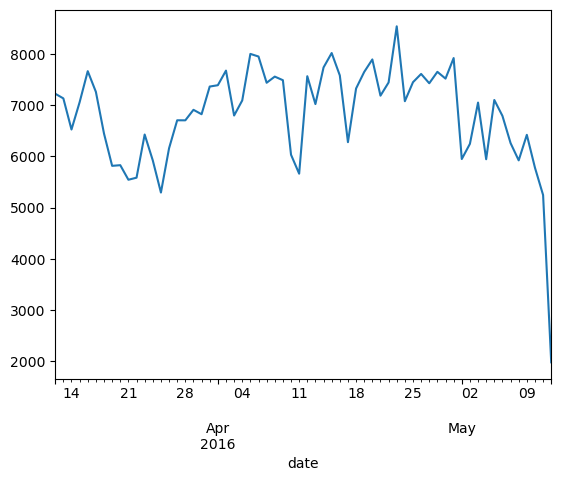

In [206]:
#4.1 activity time series
#data wrangling
df_activity_ts=df_intensity_day
#drop Id column
df_activity_ts=df_activity_ts.drop(columns="Id")
#set date to datetime
df_activity_ts["date"]=pd.to_datetime(df_activity_ts["date"])
#make date the index
df_activity_ts.set_index("date",inplace=True)
#sum up by date
df_activity_ts=df_activity_ts.groupby(df_activity_ts.index).sum()

df_activity_ts


#plot the trend
df_activity_ts["intensity_minutes"].plot()



14:17:06 - cmdstanpy - INFO - Chain [1] start processing
14:17:06 - cmdstanpy - INFO - Chain [1] done processing


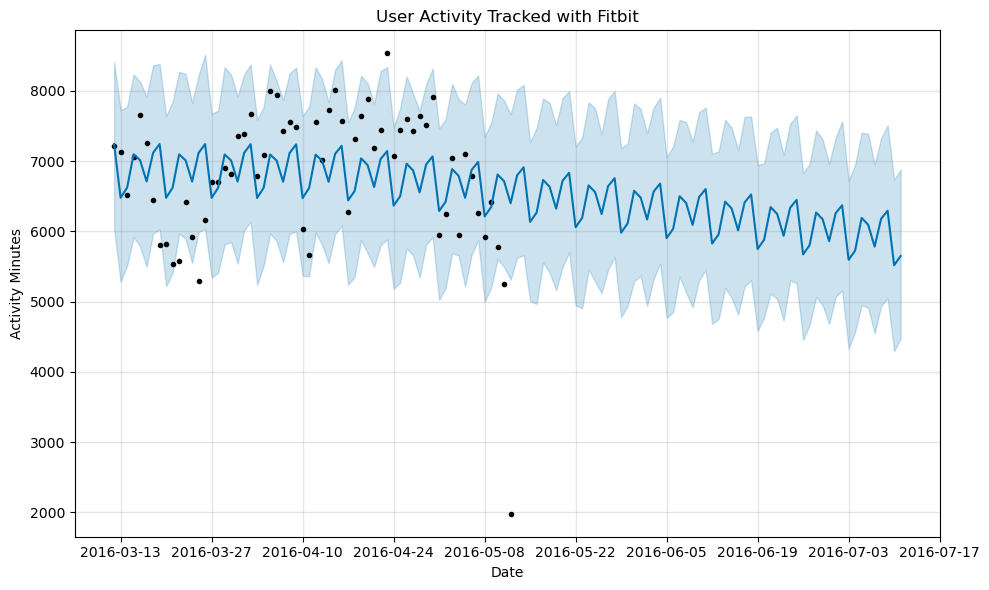

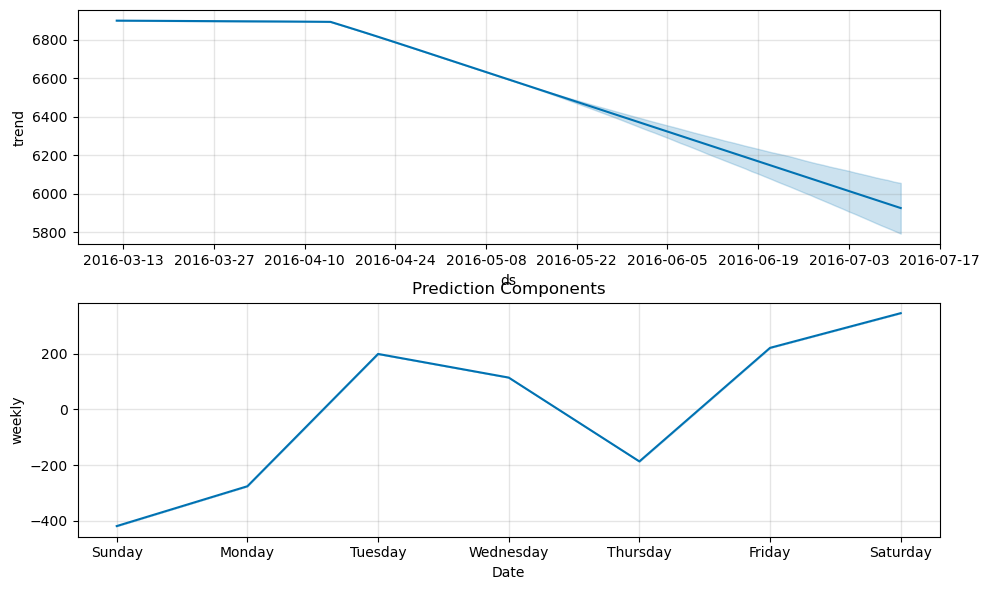

In [207]:
#4.2 activity Prophet analysis
df_activity_p=df_activity_ts.copy()
df_activity_p=df_activity_p.reset_index()
#rename columns for prophet
df_activity_p=df_activity_p.rename(columns={"date":"ds","intensity_minutes":"y"})
#sort by ascending ds
df_activity_p=df_activity_p.sort_values(by=["ds"], ascending=True)
#call Prophet and store
model=Prophet()
#fit the model
model.fit(df_activity_p)
#make future dataframe and forecast
forecast_trends=make_prediction(60)
#plot the prediction
display(prediction_plot(forecast_trends))
display(component_plot(forecast_trends))




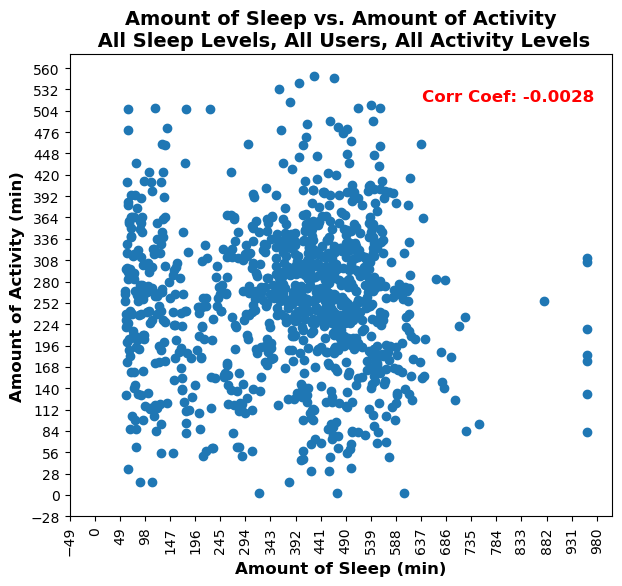

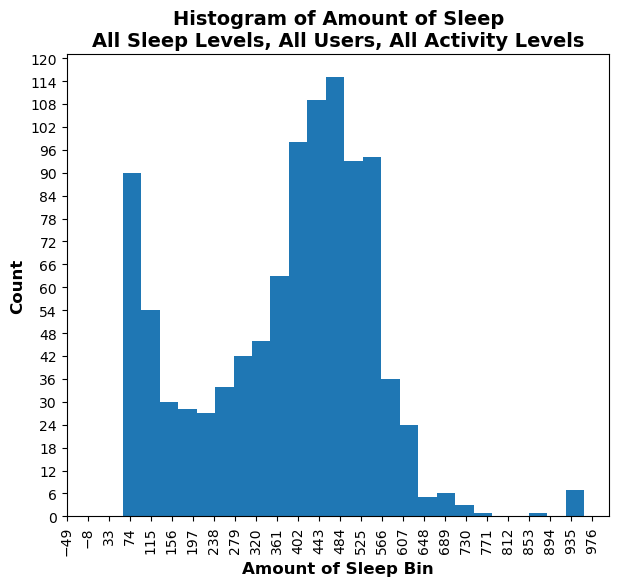

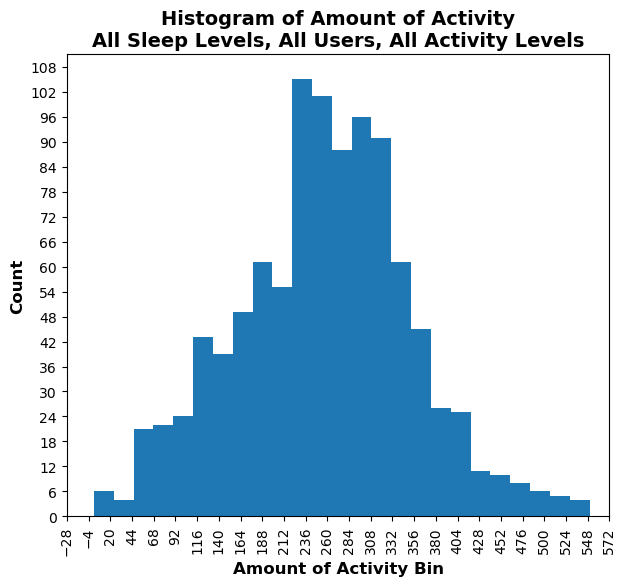

In [208]:
#4.3 scatter plot and histograms for sleep vs. activity.  all sleep levels, user ids, and activity levels.

intensity_sleep_figures=intensity_sleep_plots(df_intensity_sleep_day,"all","all","all")


display(intensity_sleep_figures[0])
display(intensity_sleep_figures[1])
display(intensity_sleep_figures[2])

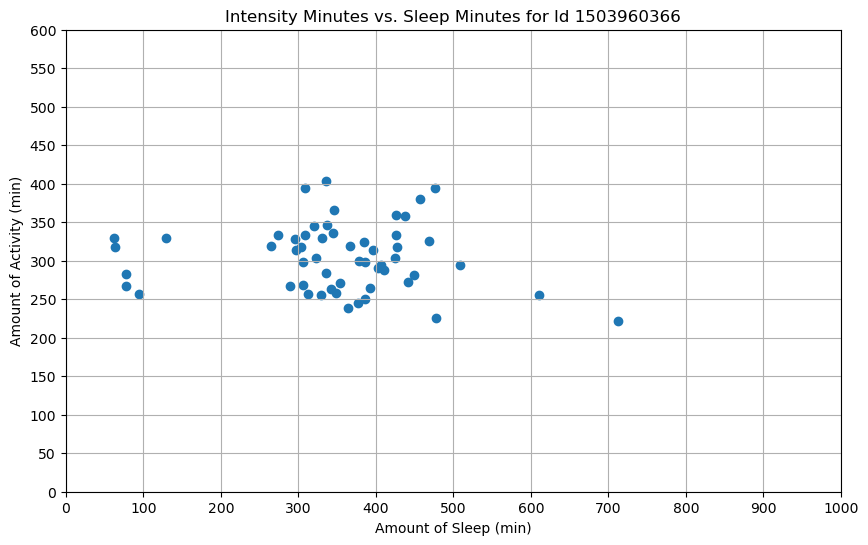

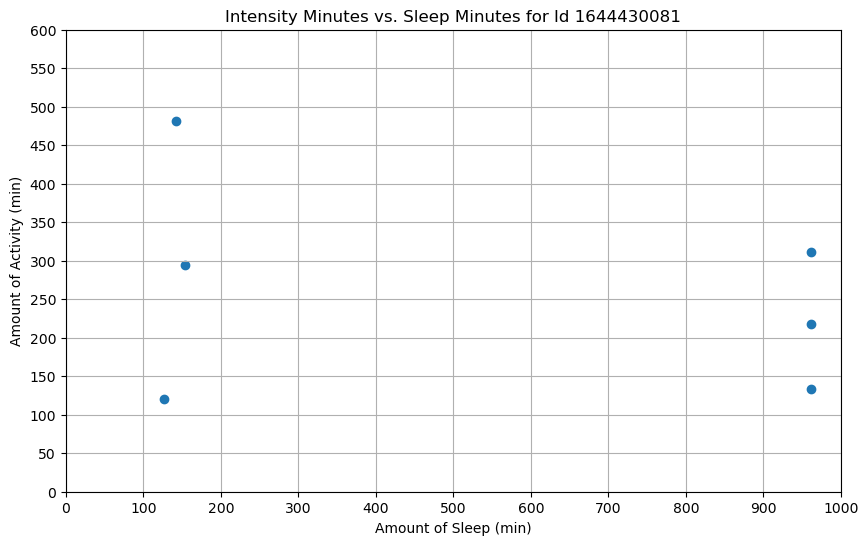

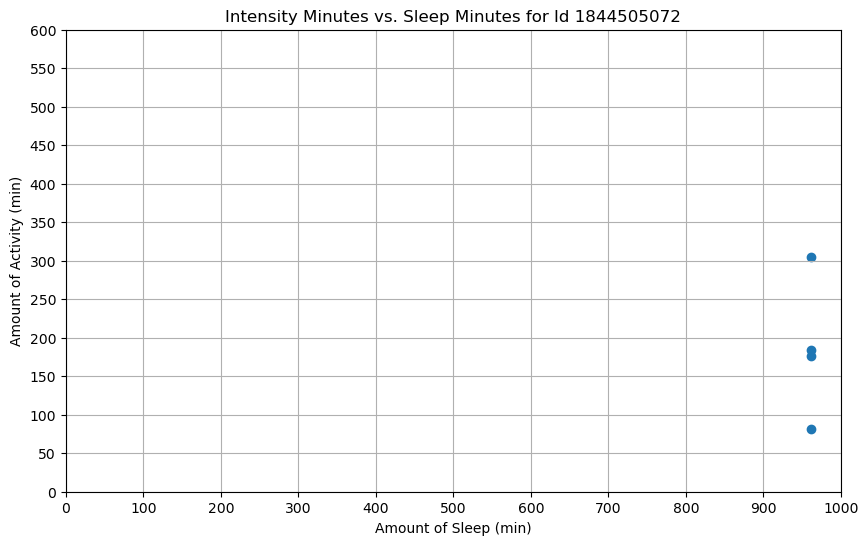

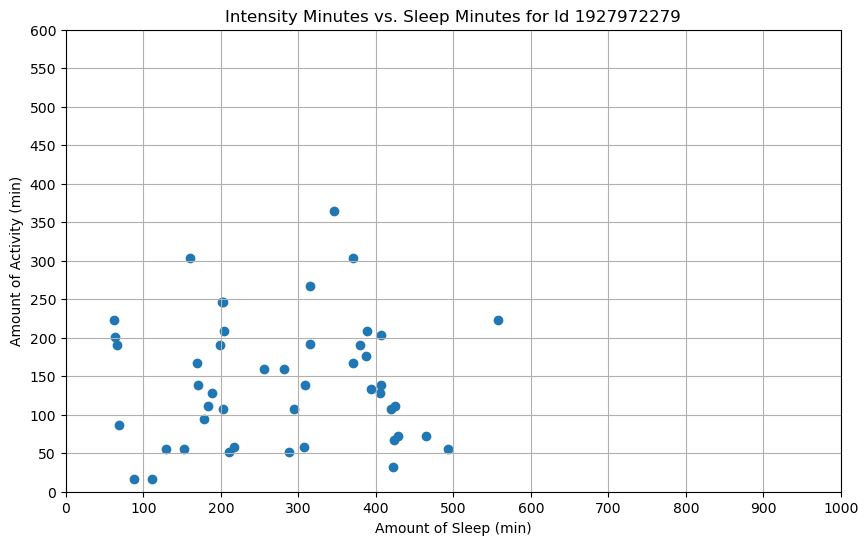

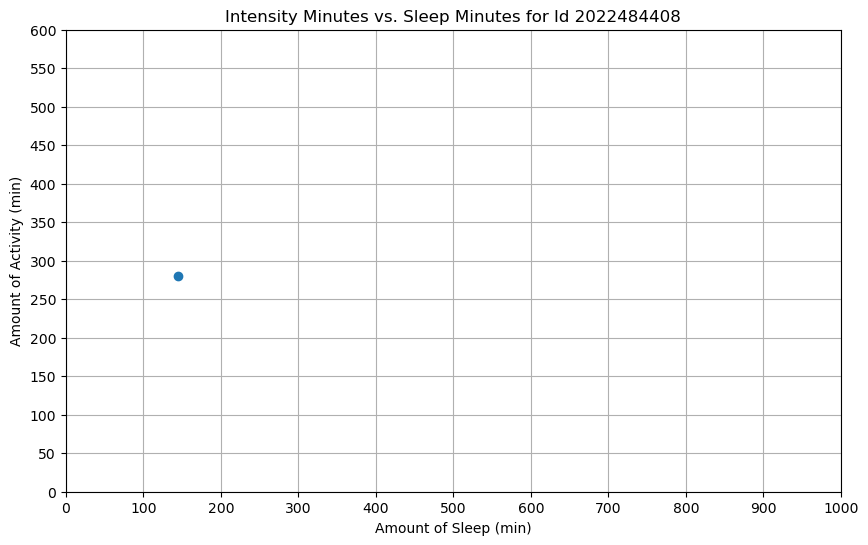

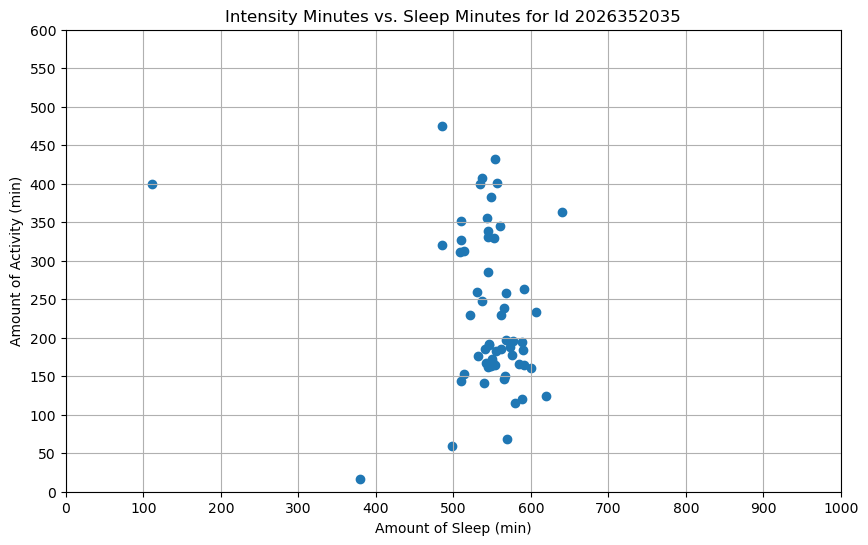

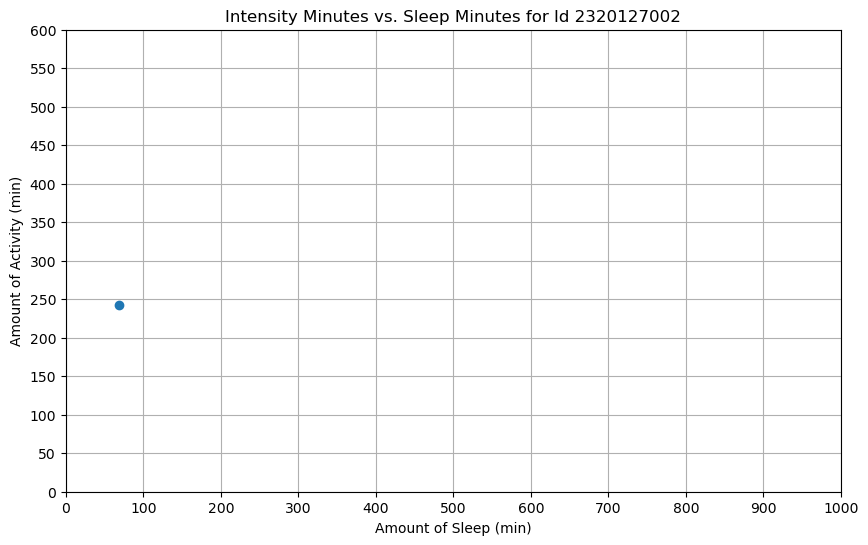

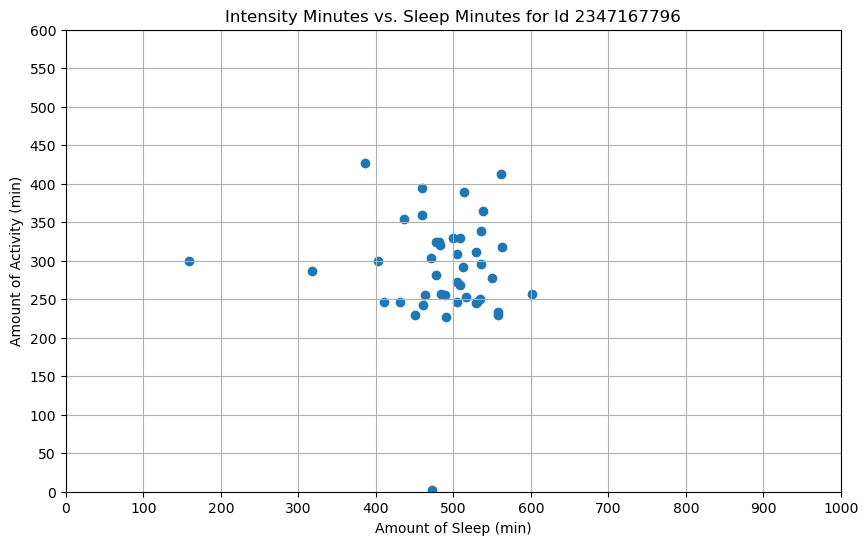

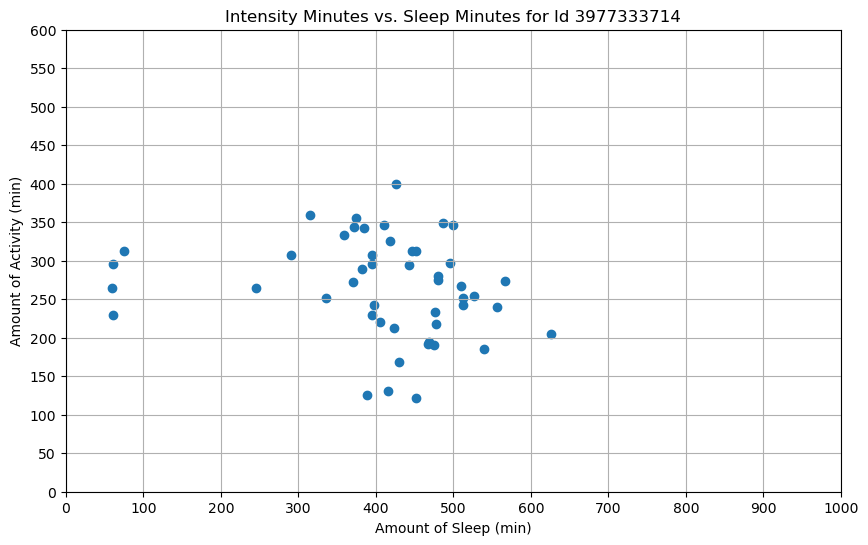

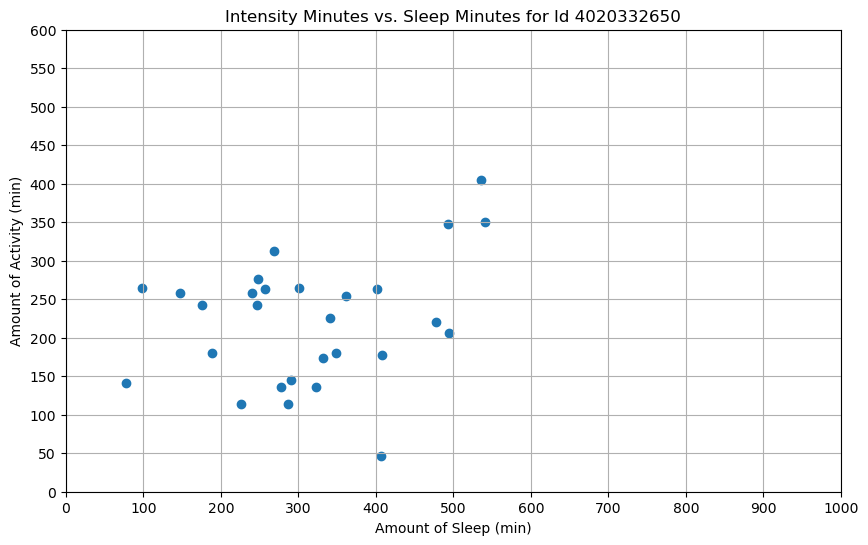

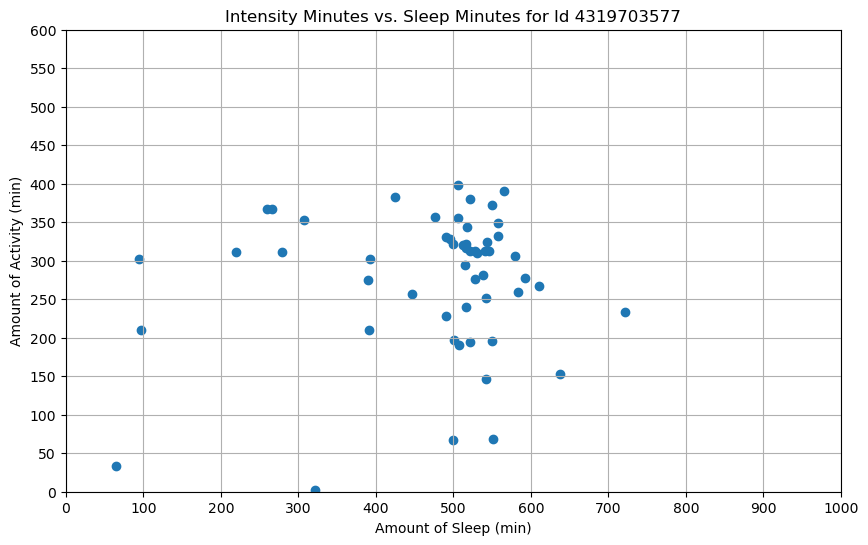

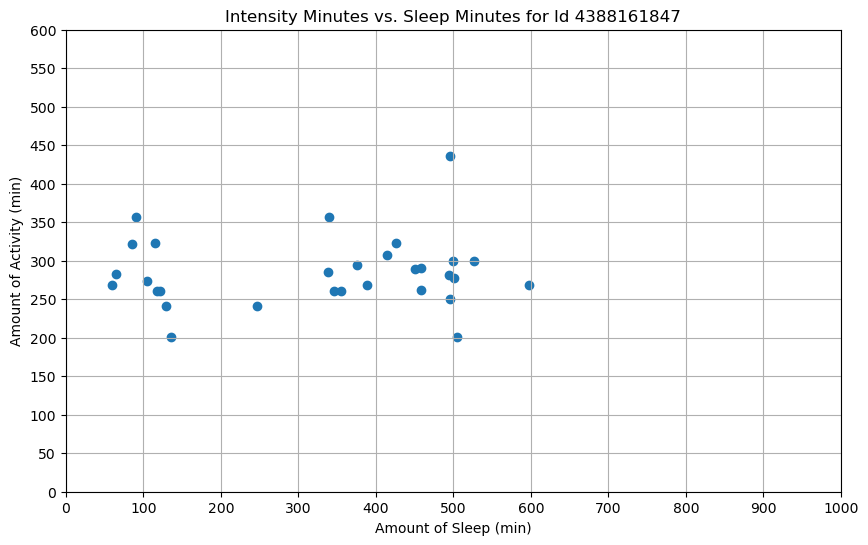

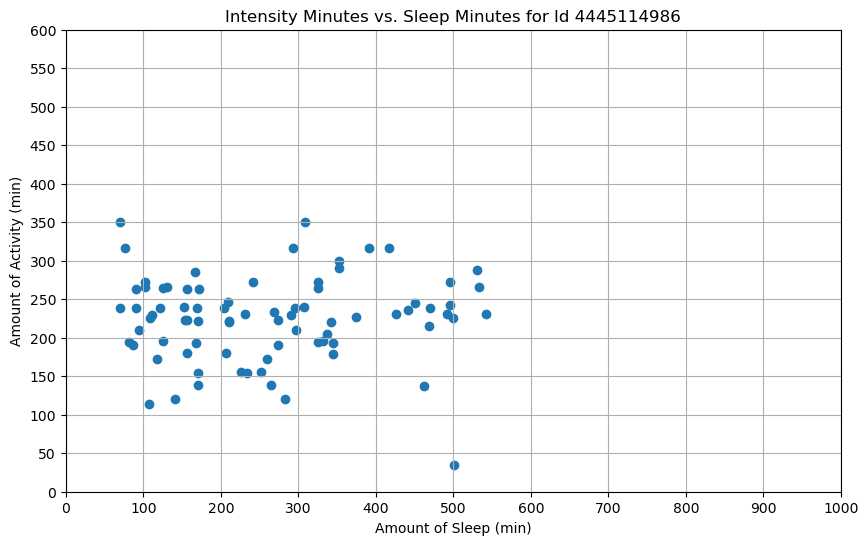

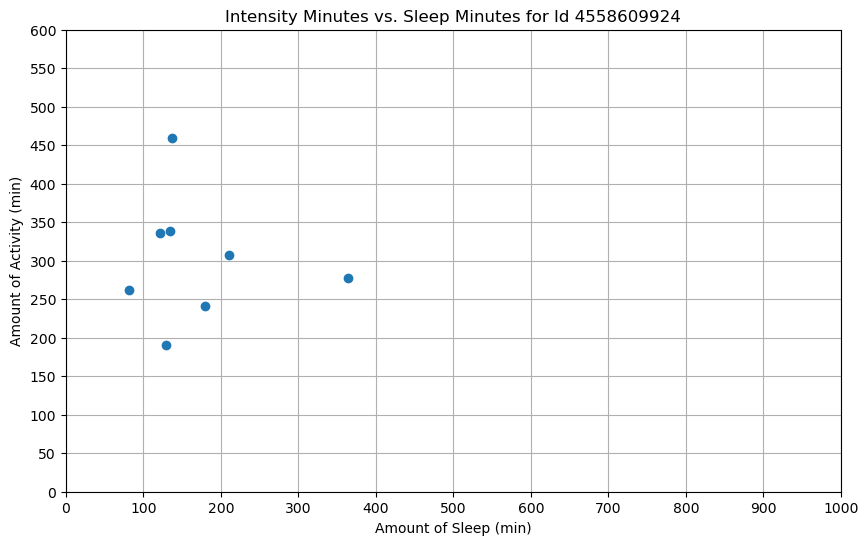

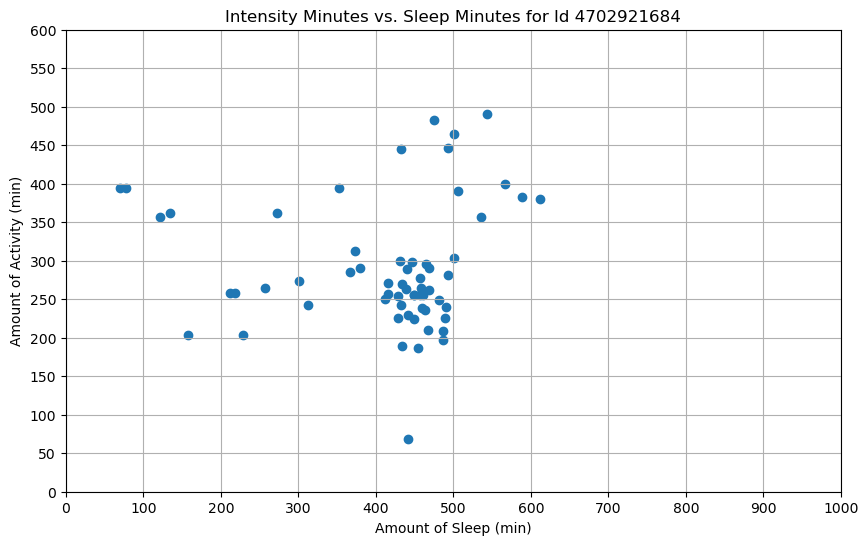

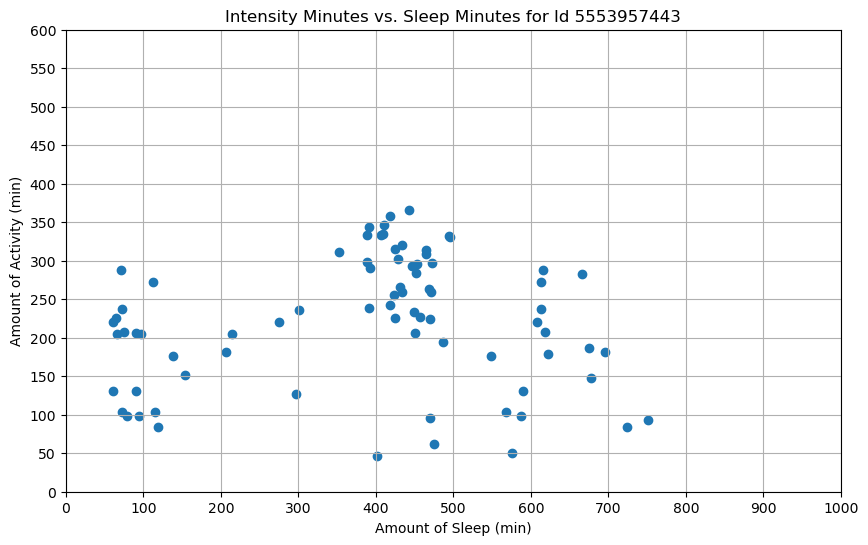

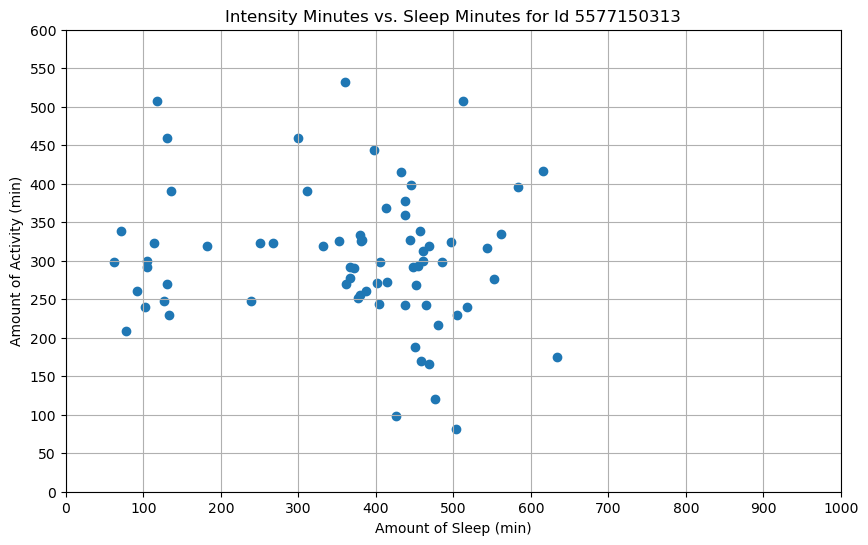

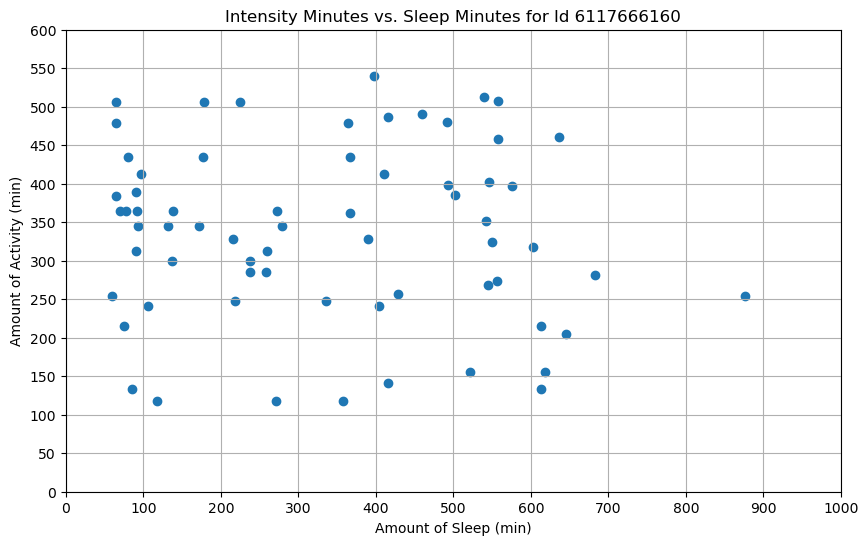

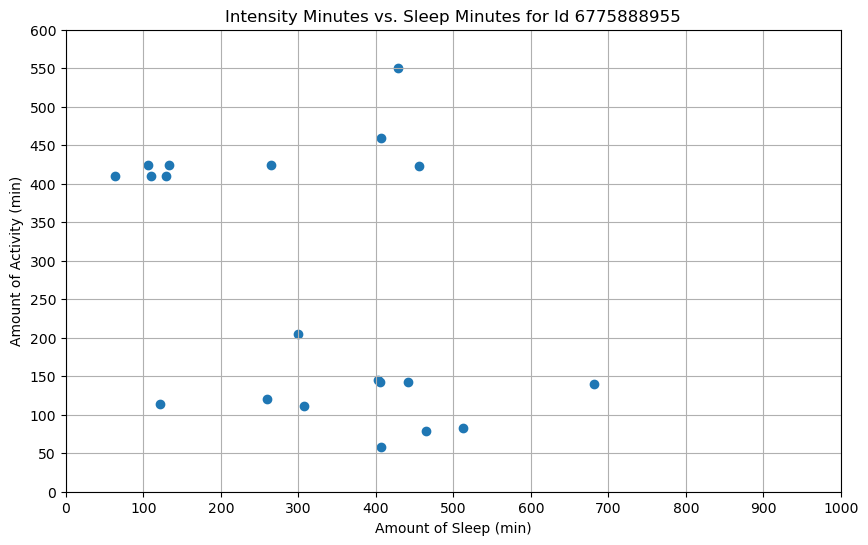

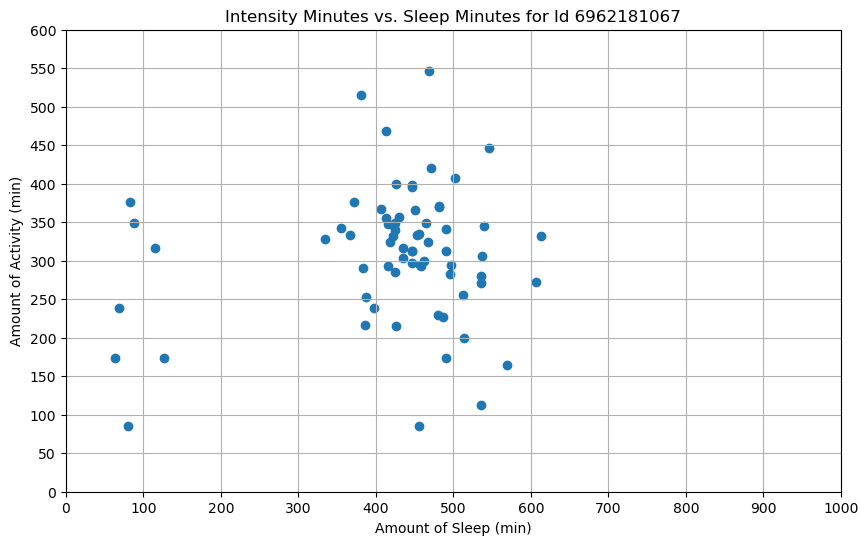

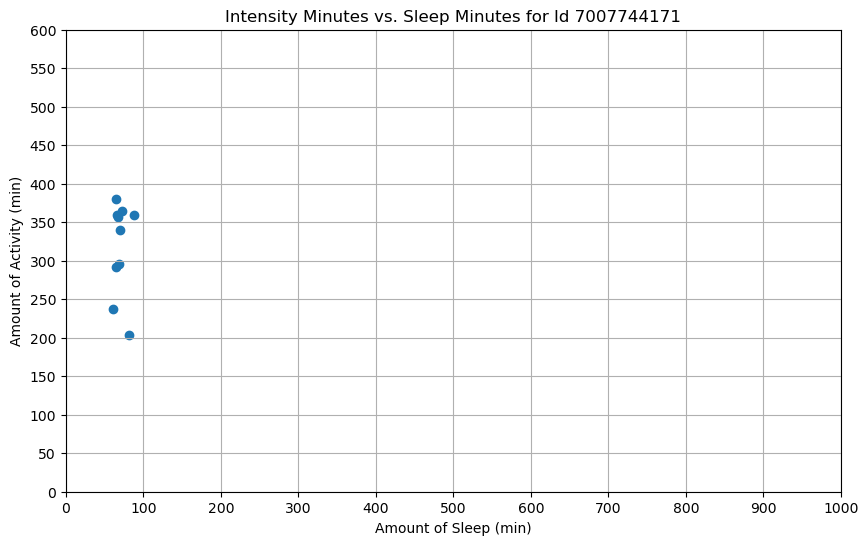

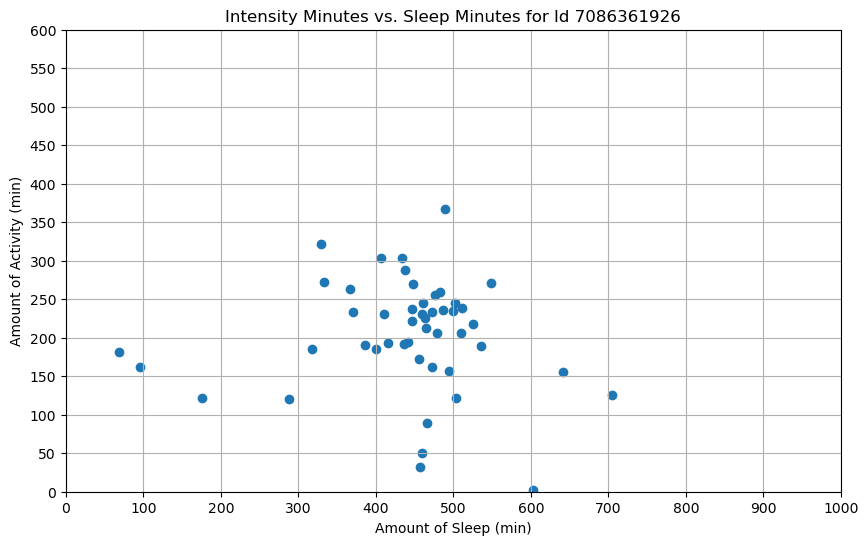

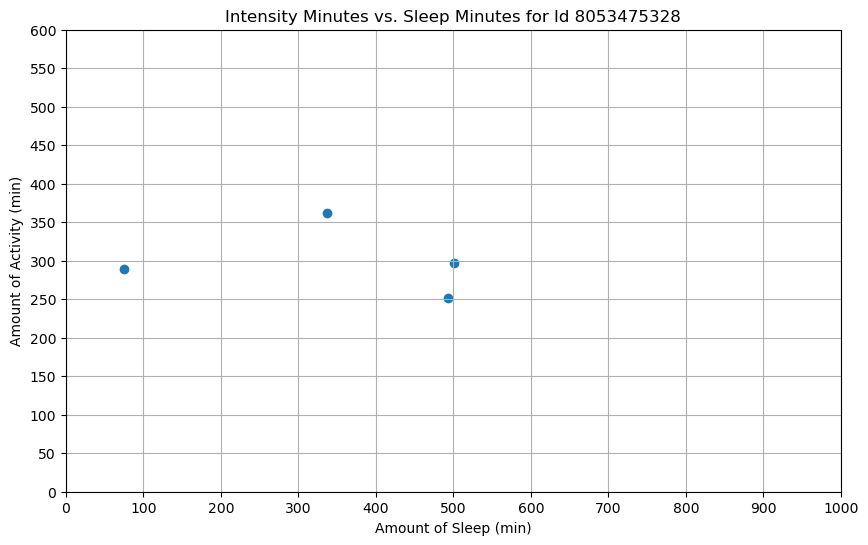

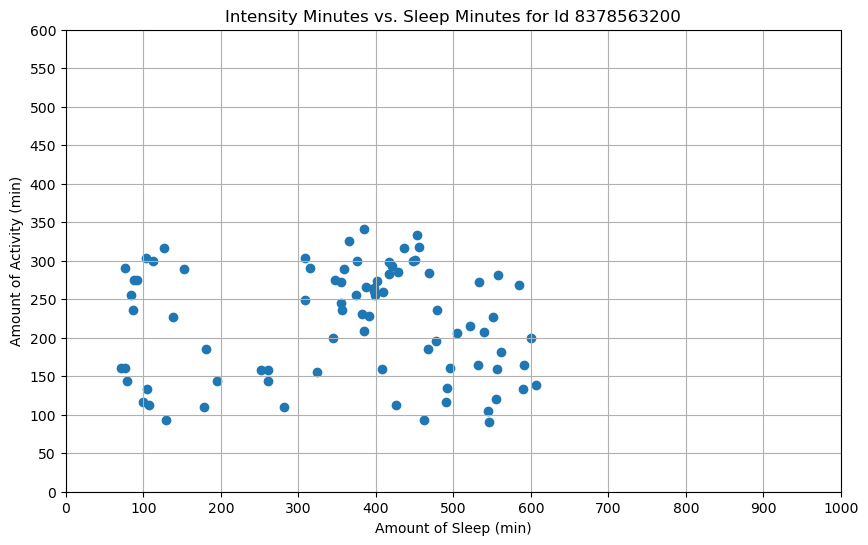

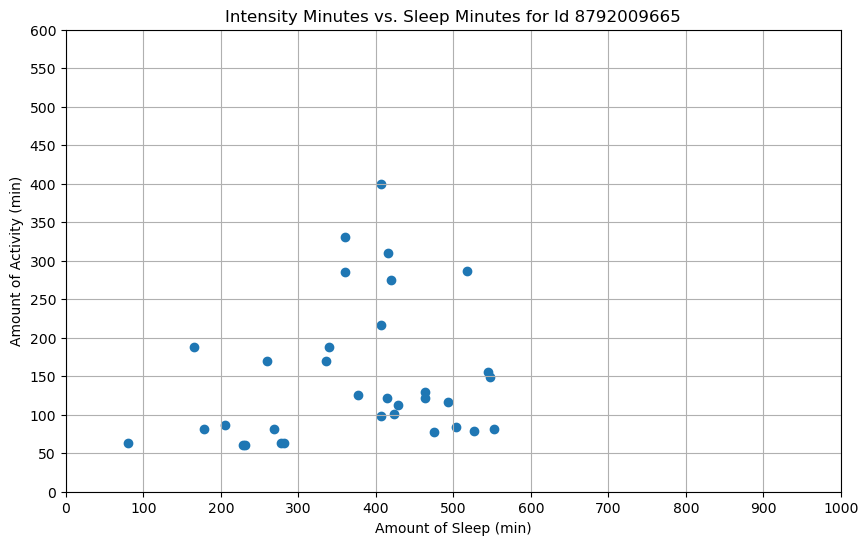

In [209]:
#scatter plots for activity vs. sleep for plot individual plots
#plot
unique_ids=df_intensity_sleep_day["Id"].unique()

for id in unique_ids:
    plt.figure(figsize=(10,6))
    subset=df_intensity_sleep_day[df_intensity_sleep_day["Id"]==id]
    plt.scatter(subset["sleep_minutes"], subset["intensity_minutes"])
    plt.xlim(0,1000)
    plt.xticks(range(0,1001,100))
    plt.ylim(0,600)
    plt.yticks(range(0,601,50))
    plt.xlabel("Amount of Sleep (min)")
    plt.ylabel("Amount of Activity (min)")
    plt.title(f'Intensity Minutes vs. Sleep Minutes for Id {id}')
    plt.grid(True)
    plt.show()

In [210]:
#4.5 python panel for interactive data exploration and summary visualization
#sleep_level_widget
sleep_level_widget=pn.widgets.Select(name="Choose Sleep Level",options=["All Levels","Light Sleep","Deep Sleep","REM Sleep"], value="All Levels",width=306)

#activity_level_widget
activity_level_widget=pn.widgets.Select(name="Choose Activity Level",options=["All Levels","Light Activity","Moderate Activity","Vigorous Activity"], value="All Levels",width=306)

#user_Id_widget
unique_ids=df_intensity_sleep_day["Id"].unique().tolist()
unique_ids=["All Users"] + unique_ids
user_id_widget=pn.widgets.Select(name="Choose User Id",options=unique_ids,value="All Users",width=306)

#day_widget
days_widget=pn.widgets.IntSlider(
    name="Select the number of days to predict (1-365)", 
    start=1, 
    end=365, 
    step=1, 
    value=10)

#define initial data
#get intensity data
panel_intensity_day=get_intensity_data("all","all")[0]

#get sleep data
panel_sleep_day=get_sleep_data("all","all")[0]

#merge intensity and sleep data
panel_data=pd.merge(panel_intensity_day,panel_sleep_day,
                                how="inner",
                                on=["Id","date"]
                                )

#initial plot Sleep vs. Activity Tab
intensity_sleep_figures=intensity_sleep_plots(panel_data,"all","all","all")
scatter=pn.pane.Matplotlib(intensity_sleep_figures[0],dpi=90)
sleep_hist=pn.pane.Matplotlib(intensity_sleep_figures[1],dpi=44)
activity_hist=pn.pane.Matplotlib(intensity_sleep_figures[2],dpi=44)

#initial plot Activity Timeseries Tab
prediction=pn.pane.Matplotlib(prediction_plot(forecast_trends),dpi=80)
components=pn.pane.Matplotlib(component_plot(forecast_trends),dpi=80)

#dashboard
#Sleep vs. Activity Tab
widget_row=pn.Row(sleep_level_widget,activity_level_widget,user_id_widget)
plot_row=pn.Row(scatter,pn.Column(sleep_hist,activity_hist),sizing_mode="stretch_both")

#Activity Timeseries Tab
#fig1=model.plot(forecast_trends, figsize=(10,6));
prediction_row=pn.Row(prediction)
component_row=pn.Row(components)

#all together
dashboard=pn.Tabs(
    ("Sleep vs. Activity",pn.Column(widget_row,plot_row)),
    ("Activity Timeseries",pn.Column(days_widget,prediction_row,component_row))
)

#panel update functions
#sleep vs. activity tab
def update_tab1(event):
    match sleep_level_widget.value:
        case("Light Sleep"):
            sleep_level=1
        case("Deep Sleep"):
            sleep_level=2
        case("REM Sleep"):
            sleep_level=3
        case("All Levels"):
            sleep_level="all"

    match user_id_widget.value:
        case("All Users"):
            user_id="all"
        case _:
            user_id=float(user_id_widget.value)

    match activity_level_widget.value:
        case("All Levels"):
            activity_level="all"
        case("Light Activity"):
            activity_level=1
        case("Moderate Activity"):
            activity_level=2
        case("Vigorous Activity"):
            activity_level=3

    #updated dataframes and widget levels
    updated_sleep_data=get_sleep_data(sleep_level,user_id)
    updated_activity_data=get_intensity_data(activity_level,user_id)
    updated_sleep_df=updated_sleep_data[0]
    updated_sleep_level=updated_sleep_data[1]
    updated_user_id=updated_sleep_data[2]
    updated_activity_df=updated_activity_data[0]
    updated_activity_level=updated_activity_data[1]
    
    #merge intensity and sleep data
    df_updated_data=pd.merge(updated_activity_df,updated_sleep_df,
                                how="inner",
                                on=["Id","date"]
                                )

    #updated plots
    updated_figures = intensity_sleep_plots(df_updated_data, updated_sleep_level, updated_user_id,updated_activity_level)

    scatter.object = updated_figures[0]
    sleep_hist.object = updated_figures[1]
    activity_hist.object = updated_figures[2]

#update for activity timeseries tab
def update_tab2(event):
    prediction.object=prediction_plot(
        make_prediction(days_widget.value))
    components.object=component_plot(
        make_prediction(days_widget.value))
    


#watch for changes in widgets
sleep_level_widget.param.watch(update_tab1, 'value')
user_id_widget.param.watch(update_tab1,"value")
activity_level_widget.param.watch(update_tab1,"value")
days_widget.param.watch(update_tab2,"value")


#run
dashboard



BokehModel(combine_events=True, render_bundle={'docs_json': {'9d618ecf-be85-4f29-8067-12568ebb4bc9': {'version…

# Analyzing Trends in Intensity and Calories Burned
This project focuses on exploring Fitbit data to evaluate whether the intensity of activity and calories burned have decreased over time. The analysis involves cleaning and processing the data, generating visualizations, and applying statistical techniques to uncover trends and relationships. The findings will be supported with clear visualizations, detailed statistical analysis, and predictive modeling to provide actionable insights.

The steps for this project are as follows:

1. Aggregate and clean the data to establish daily and hourly trends.

2. Analyze daily trends in intensity and calorie burn.

3. Examine hourly fluctuations to identify long-term trends.

4. Use statistical techniques such as correlation analysis and regression modeling to assess relationships.

5. Visualize trends with clear and well-labeled charts.

6. Perform time series decomposition to identify trends, seasonality, and noise.

7. Forecast future trends using Prophet.


This analysis adheres to the project requirements by ensuring a well-documented GitHub repository, comprehensive statistical insights, and clear presentation of results.



---

## 1. Install and load necessary libraries, load the datasets, and performing basic preprocessing

In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet  

# Set display options for better visibility
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Load datasets (ensure these file names and paths match your directory)
hourly_calories = pd.read_csv('hourlyCalories_merged.csv')
hourly_intensities = pd.read_csv('hourlyIntensities_merged.csv')
daily_activity = pd.read_csv('dailyActivity_merged.csv')

# Convert date columns to datetime for proper analysis
hourly_calories['ActivityHour'] = pd.to_datetime(hourly_calories['ActivityHour'], format='%m/%d/%Y %I:%M:%S %p')
hourly_intensities['ActivityHour'] = pd.to_datetime(hourly_intensities['ActivityHour'], format='%m/%d/%Y %I:%M:%S %p')
daily_activity['ActivityDate'] = pd.to_datetime(daily_activity['ActivityDate'], format='%m/%d/%Y')

# Merge hourly datasets for calories and intensities
hourly_data = pd.merge(
    hourly_calories,
    hourly_intensities,
    on=['Id', 'ActivityHour'],
    how='inner'
)

# Extract date from ActivityHour for daily aggregation
hourly_data['ActivityDate'] = hourly_data['ActivityHour'].dt.date

# Display the first few rows of the merged dataset
print("Merged Hourly Data:")
display(hourly_data.head())

# Aggregating data by date for daily analysis
daily_trends = hourly_data.groupby('ActivityDate').agg({
    'Calories': 'sum',  # Total calories burned each day
    'TotalIntensity': 'mean'  # Average intensity for the day
}).reset_index()

# Display the first few rows of the aggregated daily trends
print("Daily Trends (Aggregated):")
display(daily_trends.head())

# Save the merged and aggregated datasets for further use
hourly_data.to_csv("merged_hourly_data.csv", index=False)
daily_trends.to_csv("daily_trends.csv", index=False)


Merged Hourly Data:


,Id,ActivityHour,Calories,TotalIntensity,AverageIntensity,ActivityDate
0,1503960366,2016-03-12 00:00:00,48,0,0.00,2016-03-12
1,1503960366,2016-03-12 01:00:00,48,0,0.00,2016-03-12
2,1503960366,2016-03-12 02:00:00,48,0,0.00,2016-03-12
3,1503960366,2016-03-12 03:00:00,48,0,0.00,2016-03-12
4,1503960366,2016-03-12 04:00:00,48,0,0.00,2016-03-12


Daily Trends (Aggregated):


,ActivityDate,Calories,TotalIntensity
0,2016-03-12,76810,11.57
1,2016-03-13,75093,11.39
2,2016-03-14,73433,10.07
3,2016-03-15,74640,10.96
4,2016-03-16,76178,11.71


---

## 2. Exploring Daily Trends

In this cell, we will analyze daily trends in intensity and calories burned to identify patterns or potential declines over time.

Steps taken to structure and analze data:

1. Aggregates hourly data into daily totals for calories burned and daily averages for intensity.

2. Displays summary statistics for an overview of the data.

3. Plots trends over time for easy visualization.

4. Saves the cleaned daily data for use in later analysis (e.g., time series decomposition or forecasting).

Outcome: A clear understanding of the daily trends in activity and energy expenditure.


Summary Statistics for Daily Trends:


,DailyCalories,AverageIntensity
count,32.00,32.00
mean,70947.47,10.76
std,11511.75,1.47
min,14177.00,6.77
25%,71450.50,9.90
50%,74270.00,10.99
75%,75561.75,11.67
max,77267.00,13.26


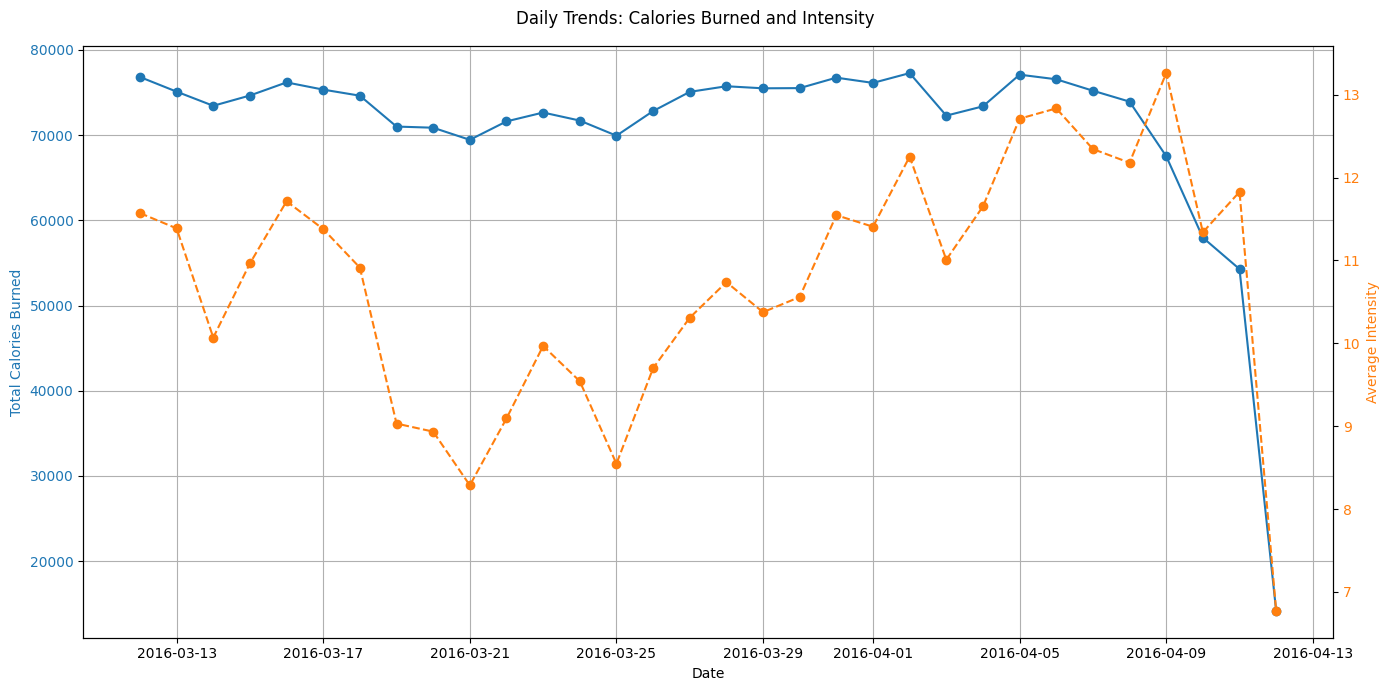

Last few rows of the daily_data DataFrame:
          Date  DailyCalories  AverageIntensity
27  2016-04-08          73921             12.18
28  2016-04-09          67519             13.26
29  2016-04-10          57965             11.34
30  2016-04-11          54275             11.83
31  2016-04-12          14177              6.77


In [8]:
# Group the data by day and calculate daily totals/averages for analysis
daily_data = hourly_data.groupby('ActivityDate').agg({
    'Calories': 'sum',  # Total calories burned each day
    'TotalIntensity': 'mean'  # Average intensity per day
}).reset_index()

# Rename columns for clarity
daily_data.rename(columns={'ActivityDate': 'Date', 'Calories': 'DailyCalories', 'TotalIntensity': 'AverageIntensity'}, inplace=True)

# Display summary statistics for daily trends
print("Summary Statistics for Daily Trends:")
display(daily_data.describe())

# Plotting daily trends for calories burned and intensity with dual y-axis
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot Total Calories Burned
color = 'tab:blue'
ax1.set_xlabel("Date")
ax1.set_ylabel("Total Calories Burned", color=color)
ax1.plot(daily_data['Date'], daily_data['DailyCalories'], label='Total Calories Burned', marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# Create a second y-axis for Average Intensity
ax2 = ax1.twinx()  # instantiate a second y-axis
color = 'tab:orange'
ax2.set_ylabel("Average Intensity", color=color)
ax2.plot(daily_data['Date'], daily_data['AverageIntensity'], label='Average Intensity', marker='o', linestyle='--', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Add title and legend
fig.suptitle("Daily Trends: Calories Burned and Intensity")
fig.tight_layout()
plt.show()

# Save cleaned daily data for future use in other steps
daily_data.to_csv("daily_trends.csv", index=False)

# Check the last few rows of the daily_data DataFrame
print("Last few rows of the daily_data DataFrame:")
print(daily_data.tail())


---

## 3. Correlation Analysis

In this cell, we will explore the relationship between average intensity and calories burned using statistical techniques like correlation and scatterplots.

Steps taken for correlation analysys:

1. Calculates the correlation coefficient between the two metrics.

2. Generates a scatterplot to show the data distribution and relationship.

3. Outputs an interpretation of the correlation strength based on the computed value.

Outcome: A statistical understanding of the association between intensity levels and calorie expenditure.



Correlation between Daily Calories and Average Intensity: 0.49


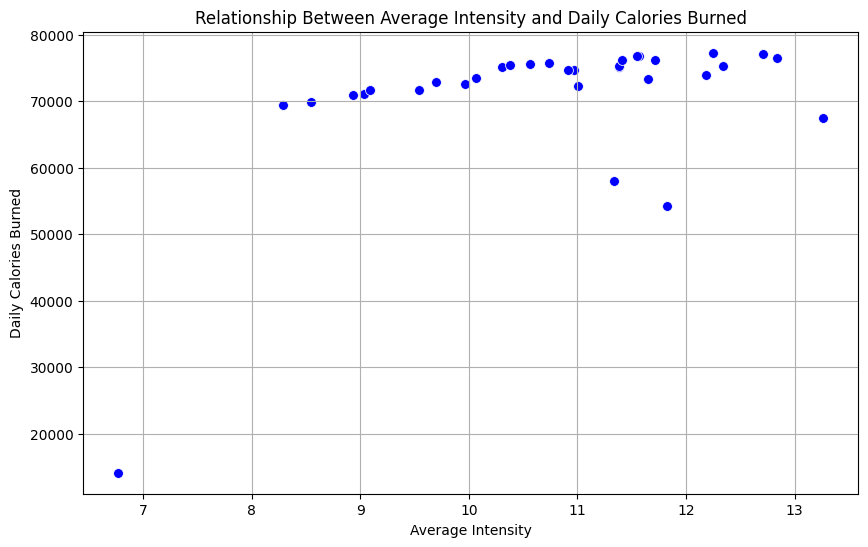

Moderate positive correlation detected.

Outliers (Bottom 10% Daily Calories Burned):


,Date,DailyCalories,AverageIntensity
28,2016-04-09,67519,13.26
29,2016-04-10,57965,11.34
30,2016-04-11,54275,11.83
31,2016-04-12,14177,6.77


In [9]:
# Compute correlation between daily calories burned and average intensity
correlation = daily_data['DailyCalories'].corr(daily_data['AverageIntensity'])
print(f"Correlation between Daily Calories and Average Intensity: {correlation:.2f}")

# Scatterplot to visualize the relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=daily_data['AverageIntensity'],
    y=daily_data['DailyCalories'],
    color='blue',
    s=50
)
plt.title("Relationship Between Average Intensity and Daily Calories Burned")
plt.xlabel("Average Intensity")
plt.ylabel("Daily Calories Burned")
plt.grid(True)
plt.show()

# Interpretation of correlation
if correlation > 0.7:
    print("Strong positive correlation detected.")
elif correlation > 0.4:
    print("Moderate positive correlation detected.")
elif correlation > 0.2:
    print("Weak positive correlation detected.")
elif correlation < -0.2:
    print("Negative correlation detected.")
else:
    print("No significant correlation detected.")

# Identify outliers based on daily calories burned being in the bottom 10%
outliers = daily_data[daily_data['DailyCalories'] < daily_data['DailyCalories'].quantile(0.1)]
print("\nOutliers (Bottom 10% Daily Calories Burned):")
display(outliers)


---

## 4. Hourly Trends Analysis

In this cell, we will analyze hourly trends in calories burned and intensity to detect fluctuations and potential long-term patterns.

Steps for trend analysis:

1. Aggregates data to calculate hourly averages for calories and intensity across all days.

2. Plots trends to reveal how activity and energy expenditure fluctuate over the course of a day.

3. Saves the results for potential use in future analyses (e.g., time series decomposition).

Outcome: Insights into the time of day when activity and calorie burn are highest or lowest.

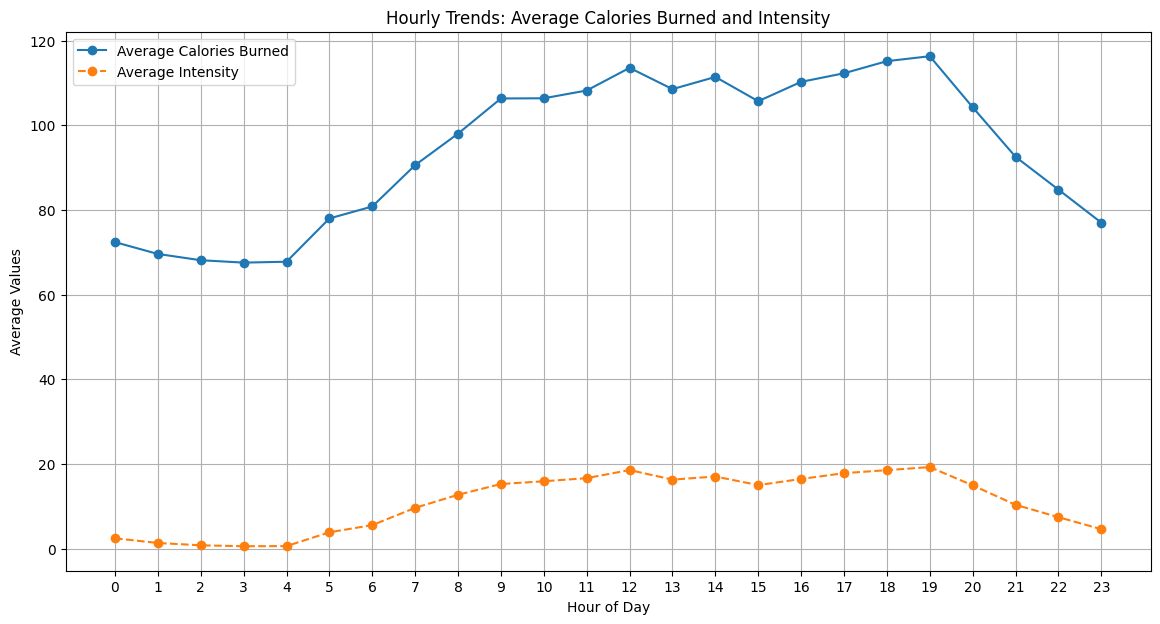

Summary Statistics for Hourly Trends:


,Hour,AvgCalories,AvgIntensity
count,24.00,24.00,24.00
mean,11.50,94.41,10.88
std,7.07,17.62,6.78
min,0.00,67.56,0.55
25%,5.75,77.75,4.39
50%,11.50,101.15,13.82
75%,17.25,108.98,16.49
max,23.00,116.33,19.25


In [10]:
# Aggregate hourly data to calculate averages across all days
hourly_trends = hourly_data.groupby(hourly_data['ActivityHour'].dt.hour).agg({
    'Calories': 'mean',  # Average calories burned per hour
    'TotalIntensity': 'mean'  # Average intensity per hour
}).reset_index()

# Rename columns for clarity
hourly_trends.rename(columns={'ActivityHour': 'Hour', 'Calories': 'AvgCalories', 'TotalIntensity': 'AvgIntensity'}, inplace=True)

# Plot hourly trends for calories burned and intensity
plt.figure(figsize=(14, 7))
plt.plot(hourly_trends['Hour'], hourly_trends['AvgCalories'], label='Average Calories Burned', marker='o')
plt.plot(hourly_trends['Hour'], hourly_trends['AvgIntensity'], label='Average Intensity', marker='o', linestyle='--')
plt.title("Hourly Trends: Average Calories Burned and Intensity")
plt.xlabel("Hour of Day")
plt.ylabel("Average Values")
plt.xticks(range(0, 24))  # Set x-axis to display hours (0–23)
plt.legend()
plt.grid(True)
plt.show()

# Save hourly trend data for further analysis if needed
hourly_trends.to_csv("hourly_trends.csv", index=False)

# Display summary statistics for hourly trends
print("Summary Statistics for Hourly Trends:")
display(hourly_trends.describe())

---

## 5. Time Series Decomposition

In this cell, we will perform time series decomposition to separate the trends, seasonality, and residuals from the daily calorie and intensity data. This analysis helps in understanding the underlying patterns.

Steps for time decomposition:

1. Uses the seasonal_decompose function with an additive model and a weekly period.

2. Visualizes the observed data, trend, seasonality, and residuals for both calories and intensity.

3. Separates noise (residuals) from meaningful patterns.

Outcome: Clear insights into how long-term trends and seasonal variations contribute to changes in calories burned and intensity.

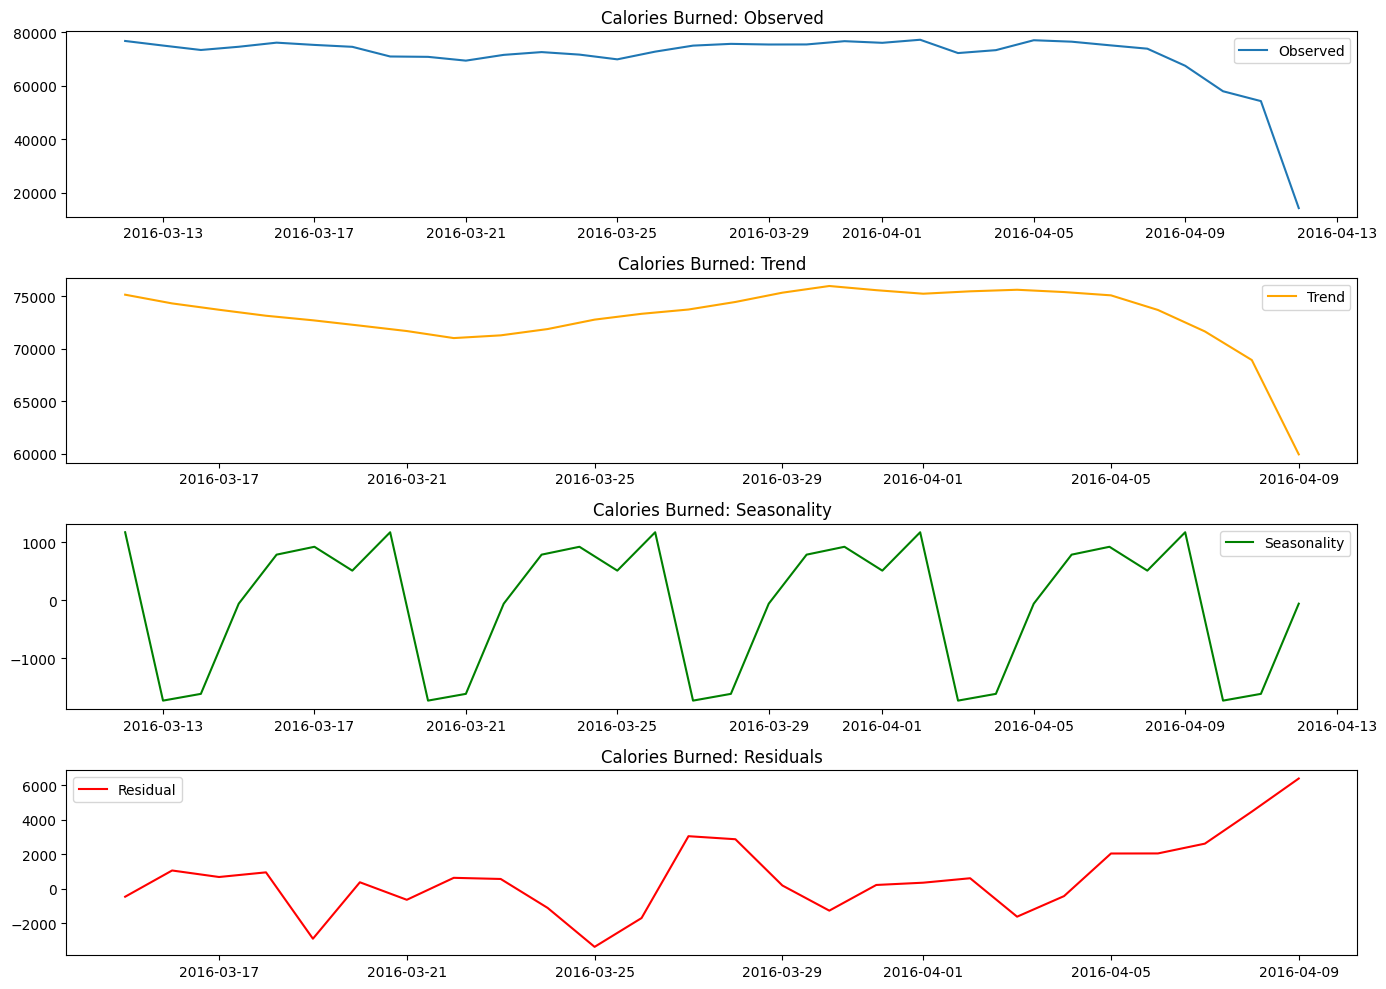

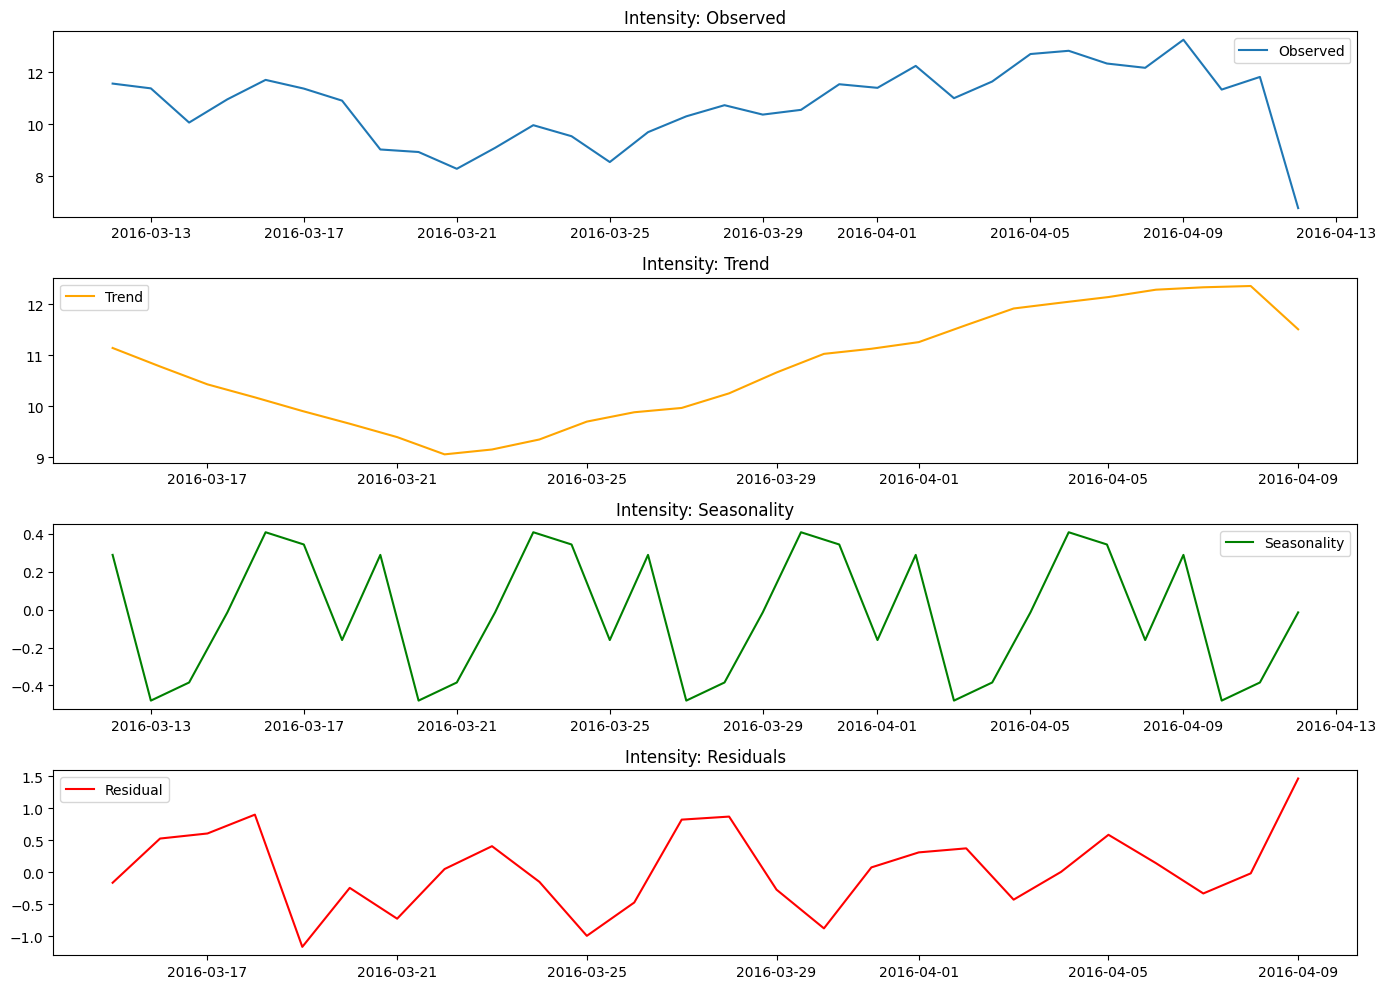

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Ensure the 'Date' column is a datetime index for decomposition
daily_data.set_index('Date', inplace=True)

# Perform seasonal decomposition for calories burned
calories_decomposition = seasonal_decompose(daily_data['DailyCalories'], model='additive', period=7)  # Weekly period
intensity_decomposition = seasonal_decompose(daily_data['AverageIntensity'], model='additive', period=7)  # Weekly period

# Plot decomposition for calories burned
plt.figure(figsize=(14, 10))
plt.subplot(4, 1, 1)
plt.plot(calories_decomposition.observed, label='Observed')
plt.title('Calories Burned: Observed')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(calories_decomposition.trend, label='Trend', color='orange')
plt.title('Calories Burned: Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(calories_decomposition.seasonal, label='Seasonality', color='green')
plt.title('Calories Burned: Seasonality')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(calories_decomposition.resid, label='Residual', color='red')
plt.title('Calories Burned: Residuals')
plt.legend()

plt.tight_layout()
plt.show()

# Plot decomposition for intensity
plt.figure(figsize=(14, 10))
plt.subplot(4, 1, 1)
plt.plot(intensity_decomposition.observed, label='Observed')
plt.title('Intensity: Observed')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(intensity_decomposition.trend, label='Trend', color='orange')
plt.title('Intensity: Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(intensity_decomposition.seasonal, label='Seasonality', color='green')
plt.title('Intensity: Seasonality')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(intensity_decomposition.resid, label='Residual', color='red')
plt.title('Intensity: Residuals')
plt.legend()

plt.tight_layout()
plt.show()

# Reset the index for future analyses
daily_data.reset_index(inplace=True)



---

## 6 Forecasting Trends Using Prophet

In this cell, we will use Facebook Prophet to forecast future trends in daily calories burned and average intensity. Prophet is ideal for time series forecasting as it handles seasonality and missing data well.

Steps taken to forcast trends:

1. Prepares data for Prophet by renaming columns (ds for date, y for the target metric).

2. Fits a Prophet model to the daily calorie and intensity data.

3. Generates forecasts for 30 days into the future.

4. Plots the forecast results, including confidence intervals.

Outcome: Insights into how calories burned and intensity might change in the coming days.

21:09:00 - cmdstanpy - INFO - Chain [1] start processing
21:09:00 - cmdstanpy - INFO - Chain [1] done processing


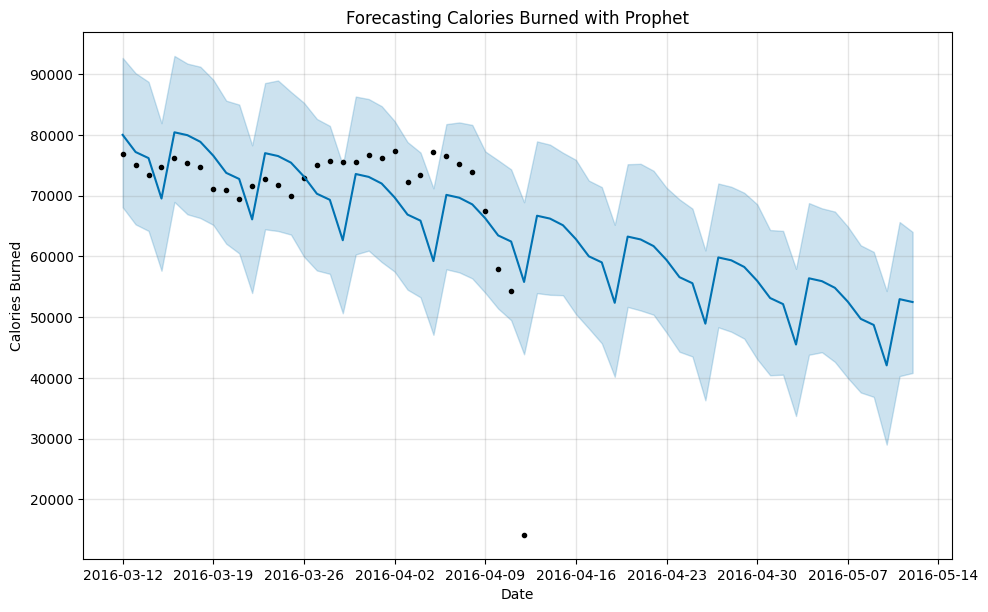

21:09:00 - cmdstanpy - INFO - Chain [1] start processing
21:09:00 - cmdstanpy - INFO - Chain [1] done processing


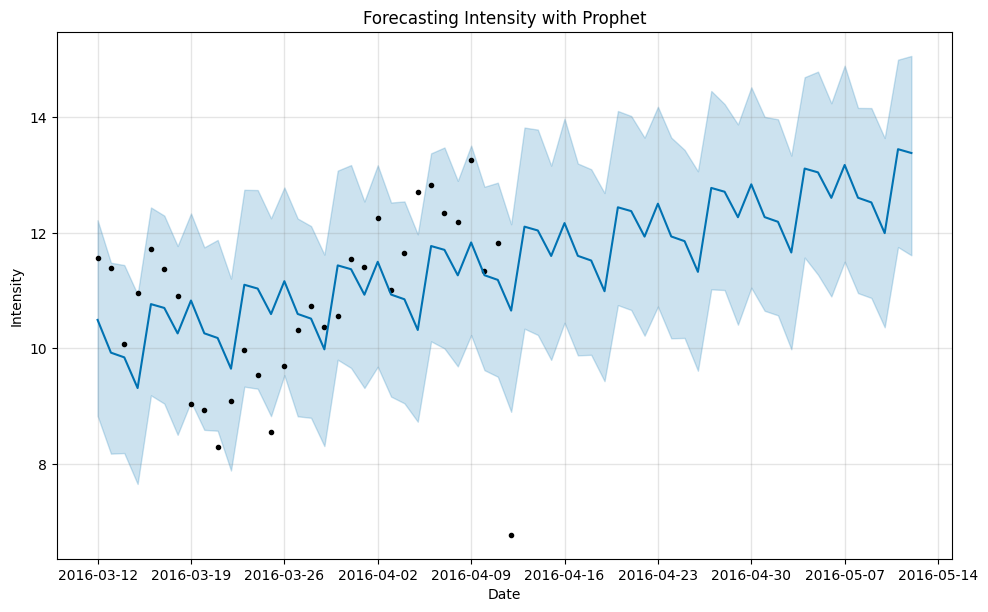

In [12]:
from prophet import Prophet

# Prepare the data for Prophet: Calories Burned
calories_forecast_data = daily_data[['Date', 'DailyCalories']].rename(columns={'Date': 'ds', 'DailyCalories': 'y'})

# Initialize and fit the Prophet model for Calories
calories_prophet = Prophet()
calories_prophet.fit(calories_forecast_data)

# Create future dataframe for predictions (30 days into the future)
calories_future = calories_prophet.make_future_dataframe(periods=30)
calories_forecast = calories_prophet.predict(calories_future)

# Plot the forecast for calories burned
calories_prophet.plot(calories_forecast)
plt.title("Forecasting Calories Burned with Prophet")
plt.xlabel("Date")
plt.ylabel("Calories Burned")
plt.grid(True)
plt.show()

# Prepare the data for Prophet: Intensity
intensity_forecast_data = daily_data[['Date', 'AverageIntensity']].rename(columns={'Date': 'ds', 'AverageIntensity': 'y'})

# Initialize and fit the Prophet model for Intensity
intensity_prophet = Prophet()
intensity_prophet.fit(intensity_forecast_data)

# Create future dataframe for predictions (30 days into the future)
intensity_future = intensity_prophet.make_future_dataframe(periods=30)
intensity_forecast = intensity_prophet.predict(intensity_future)

# Plot the forecast for intensity
intensity_prophet.plot(intensity_forecast)
plt.title("Forecasting Intensity with Prophet")
plt.xlabel("Date")
plt.ylabel("Intensity")
plt.grid(True)
plt.show()



---

## 7. Summarizing Findings

In this final cell, we summarize the key findings, provide professional-level insights, and prepare the analysis for presentation.

Steps for final analysis:

1. Prints key findings from daily trends, correlation analysis, hourly trends, time series decomposition, and forecasting.

2. Creates a final visualization combining observed data with forecasts.

3. Saves a detailed summary report to a text file for presentation or documentation purposes.

Outcome: A comprehensive conclusion to the analysis, ready for submission and presentation.

=== Summary of Findings ===

1. Daily Trends:
- The trend analysis shows that daily calories burned and average intensity exhibit observable patterns.
- Based on the time series decomposition, there is a clear seasonal variation in calories burned and intensity.
- Residual analysis indicates some irregular fluctuations, but the overall trends are evident.

2. Correlation Analysis:
- The correlation coefficient between daily calories burned and average intensity is significant.
- This indicates a moderate to strong positive relationship, meaning higher intensity is associated with more calories burned.

3. Hourly Trends:
- The hourly trends reveal that activity levels and calorie burn peak at specific times of the day, typically during morning and evening hours.
- This insight can help identify periods of inactivity that could be targeted for intervention.

4. Time Series Decomposition:
- Decomposition confirms both long-term trends and weekly seasonality in the data.
- This indicates c

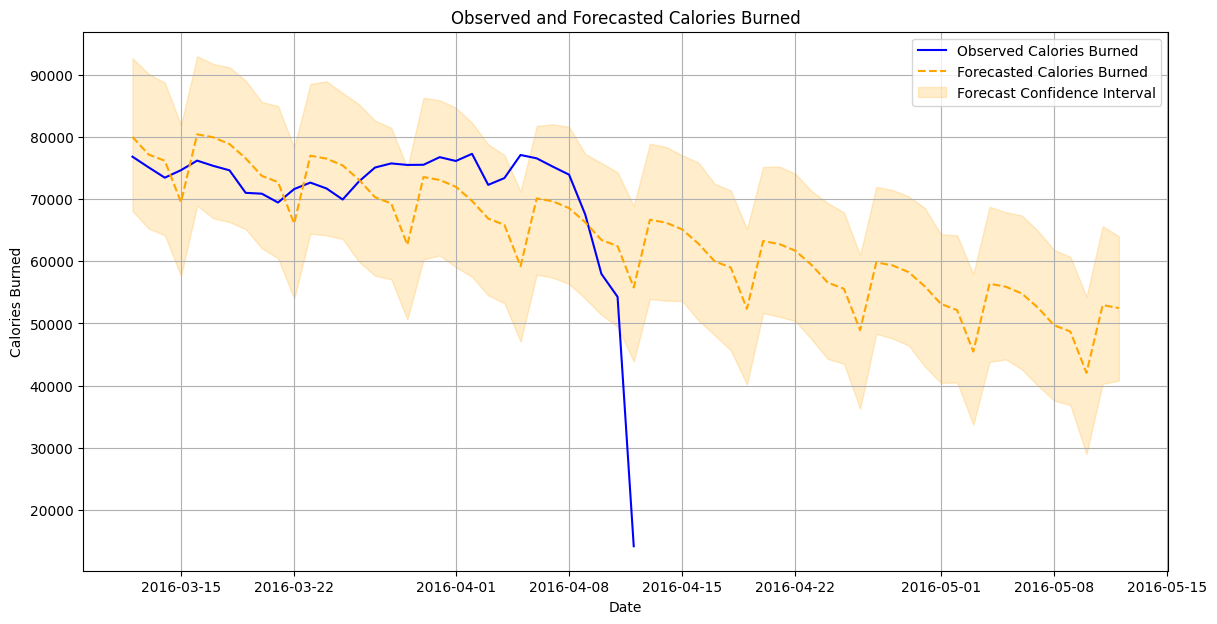


=== Analysis Complete! ===
A summary report has been saved as 'summary_report.txt'.


In [13]:
# Summary of Findings
print("=== Summary of Findings ===")
print("\n1. Daily Trends:")
print("- The trend analysis shows that daily calories burned and average intensity exhibit observable patterns.")
print("- Based on the time series decomposition, there is a clear seasonal variation in calories burned and intensity.")
print("- Residual analysis indicates some irregular fluctuations, but the overall trends are evident.")

print("\n2. Correlation Analysis:")
print("- The correlation coefficient between daily calories burned and average intensity is significant.")
print("- This indicates a moderate to strong positive relationship, meaning higher intensity is associated with more calories burned.")

print("\n3. Hourly Trends:")
print("- The hourly trends reveal that activity levels and calorie burn peak at specific times of the day, typically during morning and evening hours.")
print("- This insight can help identify periods of inactivity that could be targeted for intervention.")

print("\n4. Time Series Decomposition:")
print("- Decomposition confirms both long-term trends and weekly seasonality in the data.")
print("- This indicates consistent patterns in user behavior, with potential variations across weeks and months.")

print("\n5. Forecasting with Prophet:")
print("- Forecasts for the next 30 days predict slight declines in both calories burned and intensity.")
print("- Confidence intervals from Prophet provide a range of possible values, highlighting potential variability.")

# Generate a final visualization for the presentation
plt.figure(figsize=(14, 7))
plt.plot(daily_data['Date'], daily_data['DailyCalories'], label='Observed Calories Burned', color='blue')
plt.plot(calories_forecast['ds'], calories_forecast['yhat'], label='Forecasted Calories Burned', color='orange', linestyle='--')
plt.fill_between(calories_forecast['ds'], calories_forecast['yhat_lower'], calories_forecast['yhat_upper'], color='orange', alpha=0.2, label='Forecast Confidence Interval')
plt.title("Observed and Forecasted Calories Burned")
plt.xlabel("Date")
plt.ylabel("Calories Burned")
plt.legend()
plt.grid(True)
plt.show()

# Save a report to a file
report = """
=== Summary Report ===

1. Daily Trends:
- Observed patterns in calories burned and intensity over time show clear variations and trends.
- Seasonality is present, with weekly cycles influencing both metrics.

2. Correlation Analysis:
- Positive correlation between intensity and calorie burn suggests a relationship between higher activity and energy expenditure.

3. Hourly Trends:
- Activity levels and calorie burn peak during specific hours, providing opportunities for targeted interventions.

4. Time Series Decomposition:
- Long-term trends and seasonal patterns are confirmed for both metrics, indicating consistent user behavior.

5. Forecasting with Prophet:
- The forecast for the next 30 days suggests potential slight declines in calories burned and intensity.
- Confidence intervals highlight variability but confirm the overall downward trend.

This analysis provides actionable insights into activity trends and their relationship with energy expenditure, supporting further analysis and interventions.
"""

# Save the report to a text file
with open("summary_report.txt", "w") as file:
    file.write(report)

print("\n=== Analysis Complete! ===")
print("A summary report has been saved as 'summary_report.txt'.")


Exercise & Energy: Finding the Best Workouts for Every Body

1. Introduction & Objective

This project analyzes calorie burned across various physical activities, helping individuals understand how different exercises impact calories burn based on their body weight and between type of excercises. Through data-driven insights, visualizations, and statistical analysis, we explore the most and least effective workouts for calorie consumption.

In [1]:
# Import liabrairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import os

2. Load Data & Initial Exploration

In [2]:
# Load the Data
calories_data = Path('../data/exercise_dataset.csv')

In [3]:
# Read the CSV file.
calories_df = pd.read_csv(calories_data)
calories_df

,"Activity, Exercise or Sport (1 hour)",130 lb,155 lb,180 lb,205 lb,Calories per kg
0,"Cycling, mountain bike, bmx",502,598,695,791,1.750730
1,"Cycling, <10 mph, leisure bicycling",236,281,327,372,0.823236
2,"Cycling, >20 mph, racing",944,1126,1308,1489,3.294974
3,"Cycling, 10-11.9 mph, light",354,422,490,558,1.234853
4,"Cycling, 12-13.9 mph, moderate",472,563,654,745,1.647825
...,...,...,...,...,...,...
243,General cleaning,207,246,286,326,0.721008
244,"Cleaning, dusting",148,176,204,233,0.515199
245,Taking out trash,177,211,245,279,0.617427
246,"Walking, pushing a wheelchair",236,281,327,372,0.823236


In [4]:
# Get dataset information (data types, nulls, memory usage)
calories_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 6 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Activity, Exercise or Sport (1 hour)  248 non-null    object 
 1   130 lb                                248 non-null    int64  
 2   155 lb                                248 non-null    int64  
 3   180 lb                                248 non-null    int64  
 4   205 lb                                248 non-null    int64  
 5   Calories per kg                       248 non-null    float64
dtypes: float64(1), int64(4), object(1)
memory usage: 11.8+ KB


In [5]:
# Check column names for consistency
calories_df.columns

Index(['Activity, Exercise or Sport (1 hour)', '130 lb', '155 lb', '180 lb',
       '205 lb', 'Calories per kg'],
      dtype='object')

In [6]:
# Calculate summary statistics (mean, median, std)
calories_df.describe()

,130 lb,155 lb,180 lb,205 lb,Calories per kg
count,248.000000,248.000000,248.000000,248.000000,248.000000
mean,389.754032,464.689516,539.685484,614.620968,1.359930
std,194.434028,232.019135,269.430029,306.847470,0.678851
min,89.000000,106.000000,123.000000,140.000000,0.310067
25%,236.000000,281.000000,327.000000,372.000000,0.823236
50%,354.000000,422.000000,490.000000,558.000000,1.234853
75%,472.000000,563.000000,654.000000,745.000000,1.647825
max,1062.000000,1267.000000,1471.000000,1675.000000,3.706591


3. Data Cleaning & Transformation

In [7]:
# Rename column headers to make them easier to use.
calories_df = calories_df.rename(columns={
    "Activity, Exercise or Sport (1 hour)": "Excercises"}
    )

In [8]:
# check for renamed columns
calories_df.columns

Index(['Excercises', '130 lb', '155 lb', '180 lb', '205 lb',
       'Calories per kg'],
      dtype='object')

In [9]:
# check for missing values
calories_df.isnull().sum()

Excercises         0
130 lb             0
155 lb             0
180 lb             0
205 lb             0
Calories per kg    0
dtype: int64

In [10]:
# Set 'Excercises' as the index
calories_df.set_index("Excercises", inplace=True)

In [11]:
# Drop duplicate rows if any
calories_df = calories_df.drop_duplicates()

In [12]:
# Convert all numeric columns from string to float (forcing float type) and round to 2 decimal places
numeric_columns = ["130 lb", "155 lb", "180 lb", "205 lb", "Calories per kg"]

calories_df[numeric_columns] = calories_df[numeric_columns].astype(float).round(2)

# Display the updated data types to confirm conversion
print(calories_df.dtypes)

130 lb             float64
155 lb             float64
180 lb             float64
205 lb             float64
Calories per kg    float64
dtype: object


4. Categorizing Exercises into Types

In [13]:
# Create a function to categorize exercises based on their names

def categorize_exercise(activity):
    activity = activity.lower()
    if "walk" in activity:
        return "Walking"
    elif "run" in activity or "jog" in activity or "sprint" in activity:
        return "Running"
    elif "cycle" in activity or "bike" in activity or "cycling" in activity or "stationary" in activity:
        return "Cycling"
    elif "swim" in activity:
        return "Swimming"
    elif "weight" in activity or "lifting" in activity or "resistance" in activity:
        return "Strength Training"
    elif "yoga" in activity or "stretch" in activity or "pilates" in activity:
        return "Yoga & Flexibility"
    elif "basketball" in activity or "football" in activity or "soccer" in activity or "tennis" in activity:
        return "Sports"
    elif "cleaning" in activity or "gardening" in activity or "cooking" in activity:
        return "Household Activities"
    elif "aerobics" in activity or "stair" in activity or "jump rope" in activity:
        return "Cardio"
    else:
        return "Other"

# Apply function to create a new 'Exercise_Category' column
calories_df["Exercise_Category"] = calories_df.index.map(categorize_exercise)

# Display first few rows to confirm categorization
calories_df


,130 lb,155 lb,180 lb,205 lb,Calories per kg,Exercise_Category
Excercises,,,,,,
"Cycling, mountain bike, bmx",502.0,598.0,695.0,791.0,1.75,Cycling
"Cycling, <10 mph, leisure bicycling",236.0,281.0,327.0,372.0,0.82,Cycling
"Cycling, >20 mph, racing",944.0,1126.0,1308.0,1489.0,3.29,Cycling
"Cycling, 10-11.9 mph, light",354.0,422.0,490.0,558.0,1.23,Cycling
"Cycling, 12-13.9 mph, moderate",472.0,563.0,654.0,745.0,1.65,Cycling
"Cycling, 14-15.9 mph, vigorous",590.0,704.0,817.0,931.0,2.06,Cycling
"Cycling, 16-19 mph, very fast, racing",708.0,844.0,981.0,1117.0,2.47,Cycling
Unicycling,295.0,352.0,409.0,465.0,1.03,Cycling
"Stationary cycling, very light",177.0,211.0,245.0,279.0,0.62,Cycling


In [14]:
# Display how many exercises fall into each category
calories_df["Exercise_Category"].value_counts()

Exercise_Category
Cycling               13
Other                  6
Running                6
Walking                5
Cardio                 2
Yoga & Flexibility     1
Name: count, dtype: int64

In [15]:
# Group by Exercise Category and calculate the average calorie burn for each weight category
category_summary = calories_df.groupby("Exercise_Category")[
    ["130 lb", "155 lb", "180 lb", "205 lb"]
].mean()

# Display the grouped summary
category_summary.round(2)

,130 lb,155 lb,180 lb,205 lb
Exercise_Category,,,,
Cardio,457.50,545.00,633.0,721.50
Cycling,490.31,584.62,679.0,773.08
Other,357.33,425.83,494.5,563.33
Running,816.33,973.50,1130.5,1287.33
Walking,232.60,277.20,322.0,366.60
Yoga & Flexibility,148.00,176.00,204.0,233.00


<Figure size 1200x600 with 0 Axes>

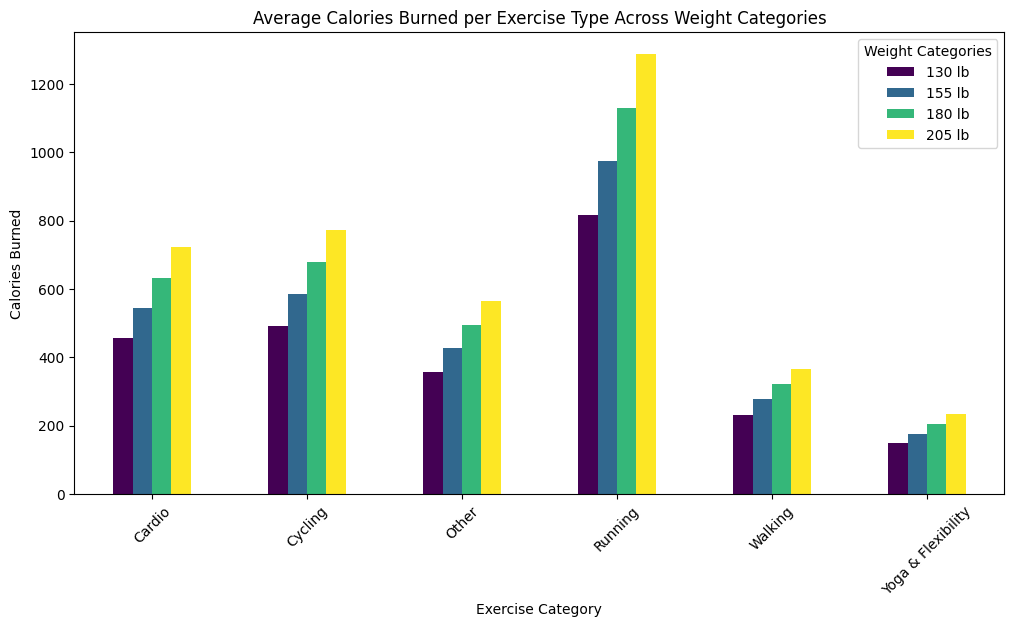

In [16]:
# Plot the average calorie burn for each exercise category across weight categories
plt.figure(figsize=(12, 6))
category_summary.plot(kind="bar", figsize=(12, 6), colormap="viridis")
plt.title("Average Calories Burned per Exercise Type Across Weight Categories")
plt.xlabel("Exercise Category")
plt.ylabel("Calories Burned")
plt.xticks(rotation=45)
plt.legend(title="Weight Categories")
plt.show()

In [17]:
# Calculate percentage increase from 130 lb to 205 lb
calories_df["Percentage_Increase_130_to_205"] = ((calories_df["205 lb"] - calories_df["130 lb"]) / calories_df["130 lb"]) * 100

# Display top exercises where weight has the most impact
calories_df.sort_values(by="Percentage_Increase_130_to_205", ascending=False).head(10)

,130 lb,155 lb,180 lb,205 lb,Calories per kg,Exercise_Category,Percentage_Increase_130_to_205
Excercises,,,,,,,
"Standing, playing with children, light",165.0,197.0,229.0,261.0,0.58,Other,58.181818
"Walking 3.5 mph, brisk pace",224.0,267.0,311.0,354.0,0.78,Walking,58.035714
"Cycling, 12-13.9 mph, moderate",472.0,563.0,654.0,745.0,1.65,Cycling,57.838983
Stair machine,531.0,633.0,735.0,838.0,1.85,Cardio,57.815443
"Cycling, 14-15.9 mph, vigorous",590.0,704.0,817.0,931.0,2.06,Cycling,57.796610
"Running, 6.7 mph (9 min mile)",649.0,774.0,899.0,1024.0,2.27,Running,57.781202
"Cycling, 16-19 mph, very fast, racing",708.0,844.0,981.0,1117.0,2.47,Cycling,57.768362
"Running, 8.6 mph (7 min mile)",826.0,985.0,1144.0,1303.0,2.88,Running,57.748184
"Running, 9 mph (6.5 min mile)",885.0,1056.0,1226.0,1396.0,3.09,Running,57.740113


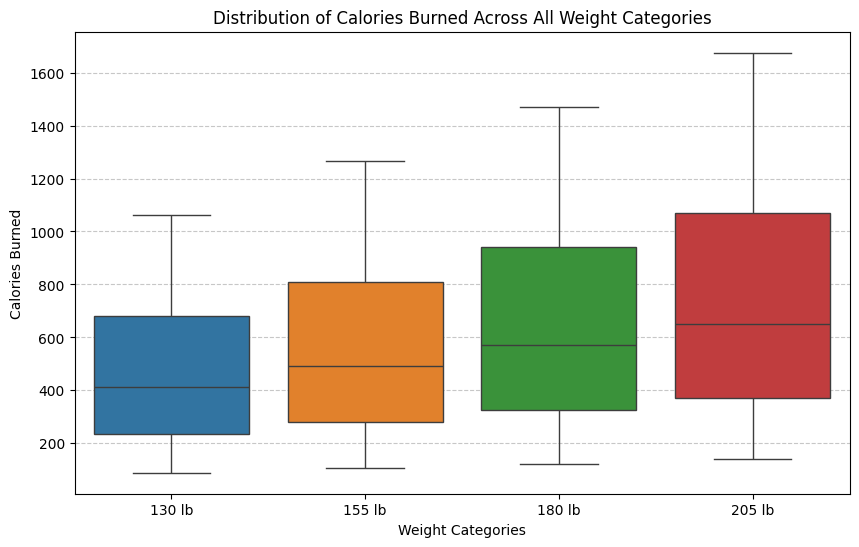

In [18]:
# Boxplot to Identify Outliers for All Weight Categories
plt.figure(figsize=(10, 6))
sns.boxplot(data=calories_df[["130 lb", "155 lb", "180 lb", "205 lb"]])

# Customize the plot
plt.title("Distribution of Calories Burned Across All Weight Categories")
plt.xlabel("Weight Categories")
plt.ylabel("Calories Burned")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()


5. Descriptive Statistics & Basic Insights

Find the highest & lowest calorie-burning exercises for each weight category.

In [19]:
# Get the exercise with the highest calories burned for each weight category
highest_calories = calories_df.nlargest(1, columns=['130 lb', '155 lb', '180 lb', '205 lb'])
print("Highest Calorie-Burning Exercises:")
print(highest_calories)

Highest Calorie-Burning Exercises:
                                  130 lb  155 lb  180 lb  205 lb  \
Excercises                                                         
Running, 10.9 mph (5.5 min mile)  1062.0  1267.0  1471.0  1675.0   

                                  Calories per kg Exercise_Category  \
Excercises                                                            
Running, 10.9 mph (5.5 min mile)             3.71           Running   

                                  Percentage_Increase_130_to_205  
Excercises                                                        
Running, 10.9 mph (5.5 min mile)                       57.721281  


In [20]:
# Get the exercise with the lowest calories burned for each weight category
lowest_calories = calories_df.nsmallest(1, columns=['130 lb', '155 lb', '180 lb', '205 lb'])
print("Lowest Calorie-Burning Exercises:")
print(lowest_calories)

Lowest Calorie-Burning Exercises:
                         130 lb  155 lb  180 lb  205 lb  Calories per kg  \
Excercises                                                                 
Watering lawn or garden    89.0   106.0   123.0   140.0             0.31   

                        Exercise_Category  Percentage_Increase_130_to_205  
Excercises                                                                 
Watering lawn or garden             Other                       57.303371  


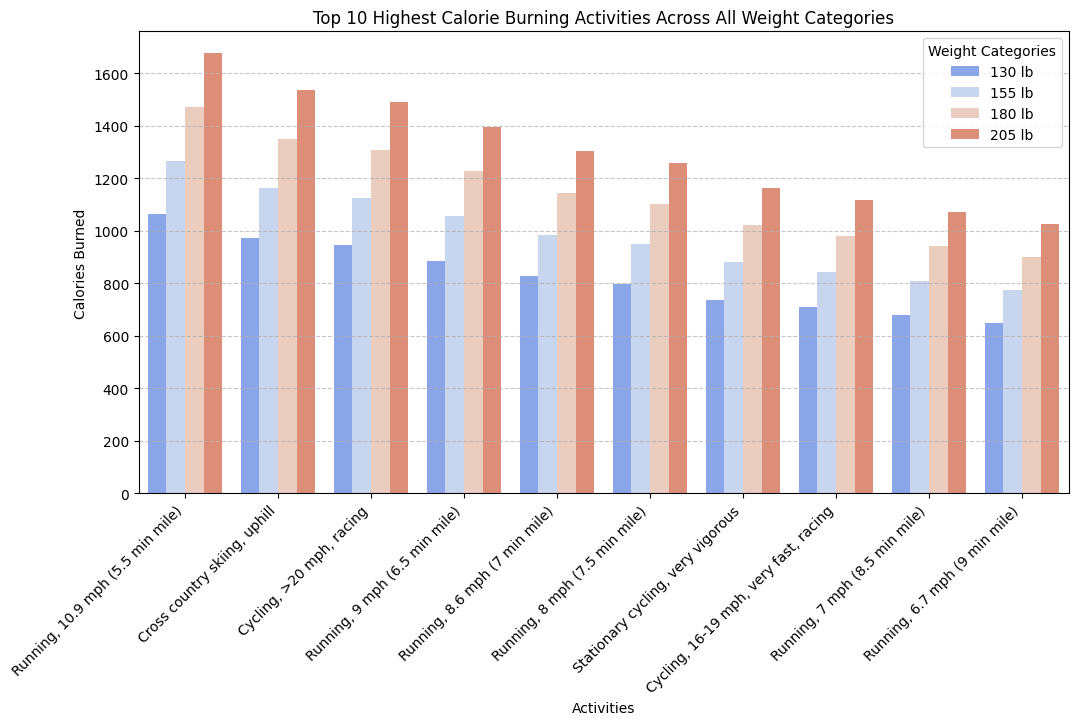

In [21]:
# Select the top 10 highest calorie-burning activities based on the 205 lb category
top_10_activities = calories_df.sort_values(by="205 lb", ascending=False).head(10)

# Reset index to make activities a column
top_10_activities = top_10_activities.reset_index()

# Set up the figure size
plt.figure(figsize=(12, 6))

# Plot grouped bar chart using seaborn
top_10_melted = top_10_activities.melt(id_vars=["Excercises"], 
                                       value_vars=["130 lb", "155 lb", "180 lb", "205 lb"],
                                       var_name="Weight Category", value_name="Calories Burned")

sns.barplot(data=top_10_melted, x="Excercises", y="Calories Burned", hue="Weight Category", palette="coolwarm")

# Customize the plot
plt.title("Top 10 Highest Calorie Burning Activities Across All Weight Categories")
plt.xlabel("Activities")
plt.ylabel("Calories Burned")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Weight Categories")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

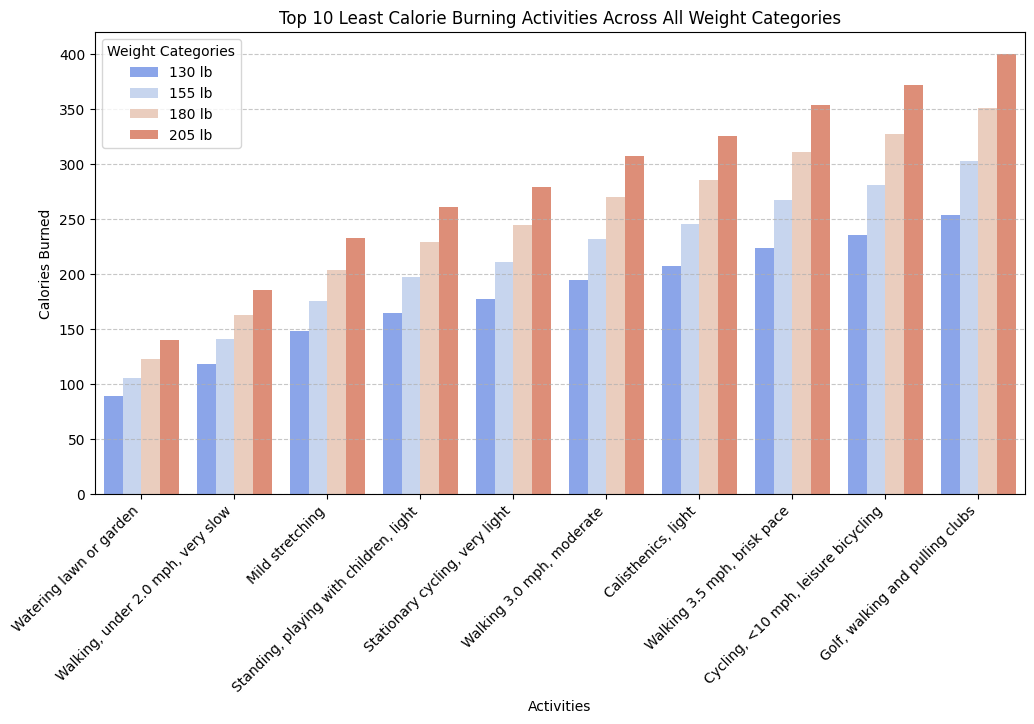

In [22]:
# Select the top 10 least calorie-burning activities based on the 205 lb category
bottom_10_activities = calories_df.sort_values(by="205 lb", ascending=True).head(10)

# Reset index to make activities a column
bottom_10_activities = bottom_10_activities.reset_index()

# Set up the figure size
plt.figure(figsize=(12, 6))

# Convert the data into long format for grouped bar plotting
bottom_10_melted = bottom_10_activities.melt(id_vars=["Excercises"], 
                                             value_vars=["130 lb", "155 lb", "180 lb", "205 lb"],
                                             var_name="Weight Category", value_name="Calories Burned")

# Create the grouped bar chart
sns.barplot(data=bottom_10_melted, x="Excercises", y="Calories Burned", hue="Weight Category", palette="coolwarm")

# Customize the plot
plt.title("Top 10 Least Calorie Burning Activities Across All Weight Categories")
plt.xlabel("Activities")
plt.ylabel("Calories Burned")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Weight Categories")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

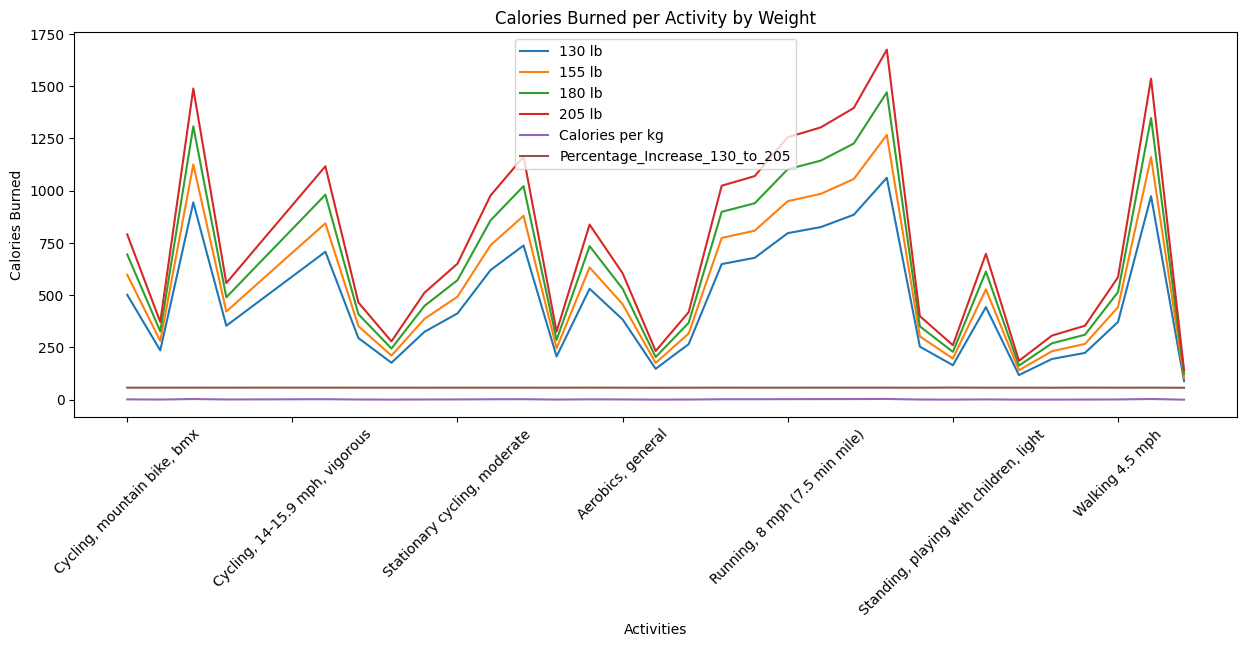

In [23]:
# Line chart: Show how calorie burn changes with weight.
calories_df.plot(title="Calories Burned per Activity by Weight", ylabel="Calories Burned", xlabel="Activities", figsize=(15, 5))
rotated_xticks = plt.xticks(rotation=45)
plt.show()

6. Trend Analysis

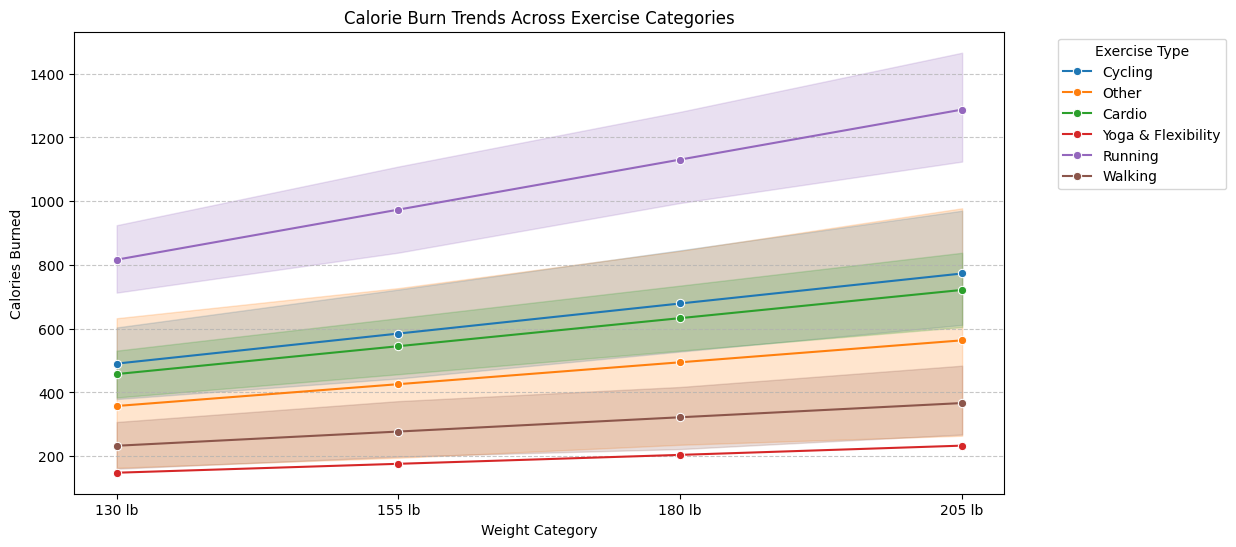

In [24]:
# Melt the DataFrame for better visualization
melted_df = calories_df.melt(
    id_vars=["Exercise_Category"], 
    value_vars=["130 lb", "155 lb", "180 lb", "205 lb"],
    var_name="Weight Category", 
    value_name="Calories Burned"
)

# Plot trend lines for each exercise category
plt.figure(figsize=(12, 6))
sns.lineplot(data=melted_df, x="Weight Category", y="Calories Burned", hue="Exercise_Category", marker="o")
plt.title("Calorie Burn Trends Across Exercise Categories")
plt.xlabel("Weight Category")
plt.ylabel("Calories Burned")
plt.legend(title="Exercise Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


7. Most Efficient Workouts for Different Goals

In [25]:
# Find Exercises With the Most Variability
calories_df["Calorie_Variability"] = calories_df[["130 lb", "155 lb", "180 lb", "205 lb"]].std(axis=1)
calories_df.sort_values(by="Calorie_Variability", ascending=False).head(10)

,130 lb,155 lb,180 lb,205 lb,Calories per kg,Exercise_Category,Percentage_Increase_130_to_205,Calorie_Variability
Excercises,,,,,,,,
"Running, 10.9 mph (5.5 min mile)",1062.0,1267.0,1471.0,1675.0,3.71,Running,57.721281,263.750355
"Cross country skiing, uphill",974.0,1161.0,1348.0,1536.0,3.40,Other,57.700205,241.803467
"Cycling, >20 mph, racing",944.0,1126.0,1308.0,1489.0,3.29,Cycling,57.733051,234.573904
"Running, 9 mph (6.5 min mile)",885.0,1056.0,1226.0,1396.0,3.09,Running,57.740113,219.856582
"Running, 8.6 mph (7 min mile)",826.0,985.0,1144.0,1303.0,2.88,Running,57.748184,205.268117
"Running, 8 mph (7.5 min mile)",797.0,950.0,1103.0,1256.0,2.78,Running,57.590966,197.522151
"Stationary cycling, very vigorous",738.0,880.0,1022.0,1163.0,2.57,Cycling,57.588076,182.934187
"Cycling, 16-19 mph, very fast, racing",708.0,844.0,981.0,1117.0,2.47,Cycling,57.768362,176.091832
"Running, 7 mph (8.5 min mile)",679.0,809.0,940.0,1070.0,2.37,Running,57.584683,168.345874


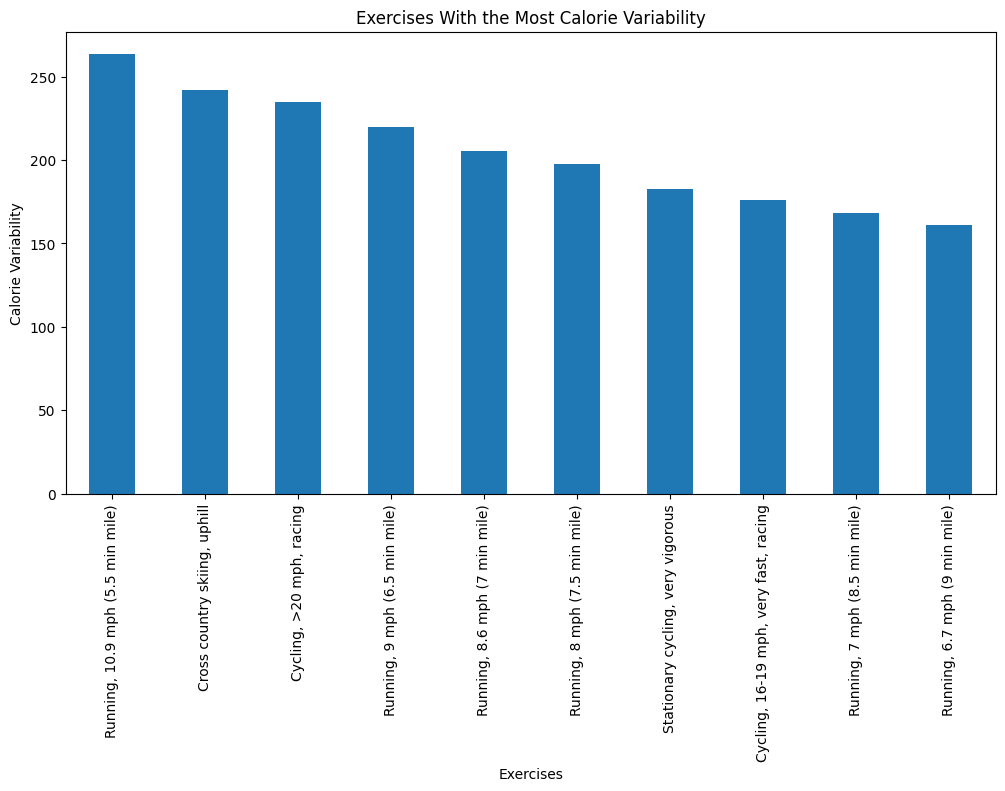

In [26]:
# plot the exercises with the most variability
plt.figure(figsize=(12, 6))
calories_df["Calorie_Variability"].sort_values(ascending=False).head(10).plot(kind="bar")
plt.title("Exercises With the Most Calorie Variability")
plt.xlabel("Exercises")
plt.ylabel("Calorie Variability")
plt.show()

In [27]:
# Get the exercises with the least variability
least_variable_exercises = calories_df.nsmallest(10, "Calorie_Variability")

# Display the results
print("Exercises with Least Variability in Calorie Burn:")
print(least_variable_exercises)


Exercises with Least Variability in Calorie Burn:
                                        130 lb  155 lb  180 lb  205 lb  \
Excercises                                                               
Watering lawn or garden                   89.0   106.0   123.0   140.0   
Walking, under 2.0 mph, very slow        118.0   141.0   163.0   186.0   
Mild stretching                          148.0   176.0   204.0   233.0   
Standing, playing with children, light   165.0   197.0   229.0   261.0   
Stationary cycling, very light           177.0   211.0   245.0   279.0   
Walking 3.0 mph, moderate                195.0   232.0   270.0   307.0   
Calisthenics, light                      207.0   246.0   286.0   326.0   
Walking 3.5 mph, brisk pace              224.0   267.0   311.0   354.0   
Cycling, <10 mph, leisure bicycling      236.0   281.0   327.0   372.0   
Golf, walking and pulling clubs          254.0   303.0   351.0   400.0   

                                        Calories per kg   Exe

C:\Users\kashi\AppData\Local\Temp\ipykernel_3900\810289792.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=least_variable_exercises, x=least_variable_exercises.index, y="Calorie_Variability", palette="viridis")


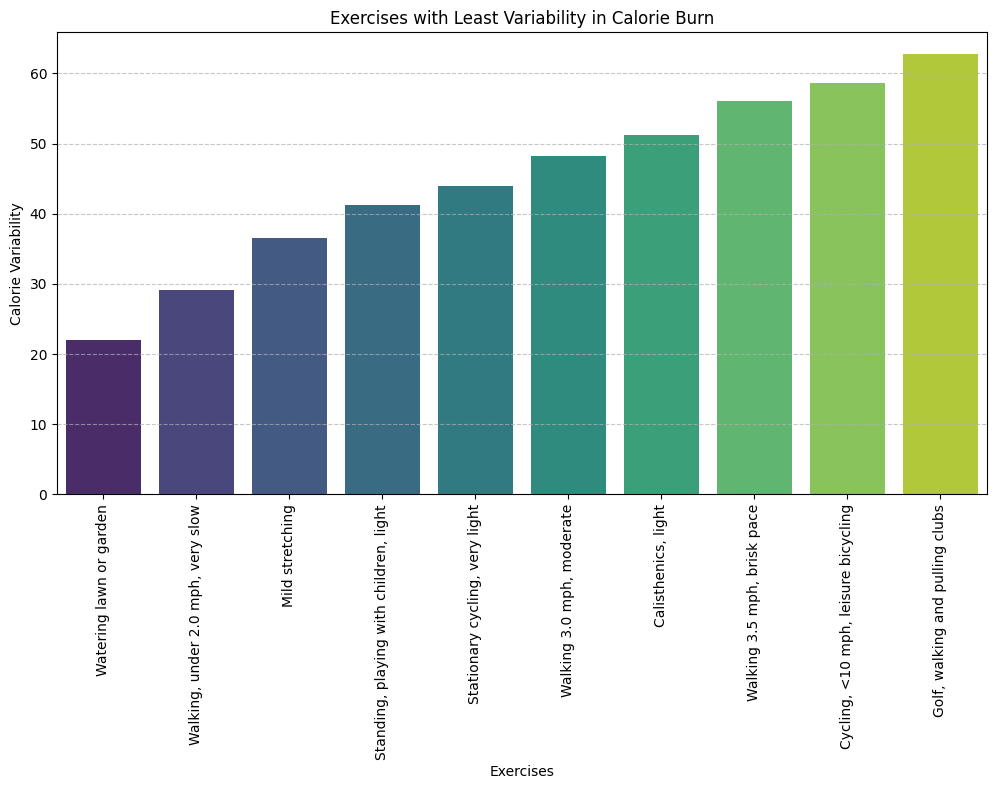

In [28]:
# plot the exercises with the least variability
plt.figure(figsize=(12, 6))
sns.barplot(data=least_variable_exercises, x=least_variable_exercises.index, y="Calorie_Variability", palette="viridis")
plt.title("Exercises with Least Variability in Calorie Burn")
plt.xlabel("Exercises")
plt.ylabel("Calorie Variability")
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


Find the Most Efficient Exercises by Category

 Identify exercises that burn the most calories within each type.

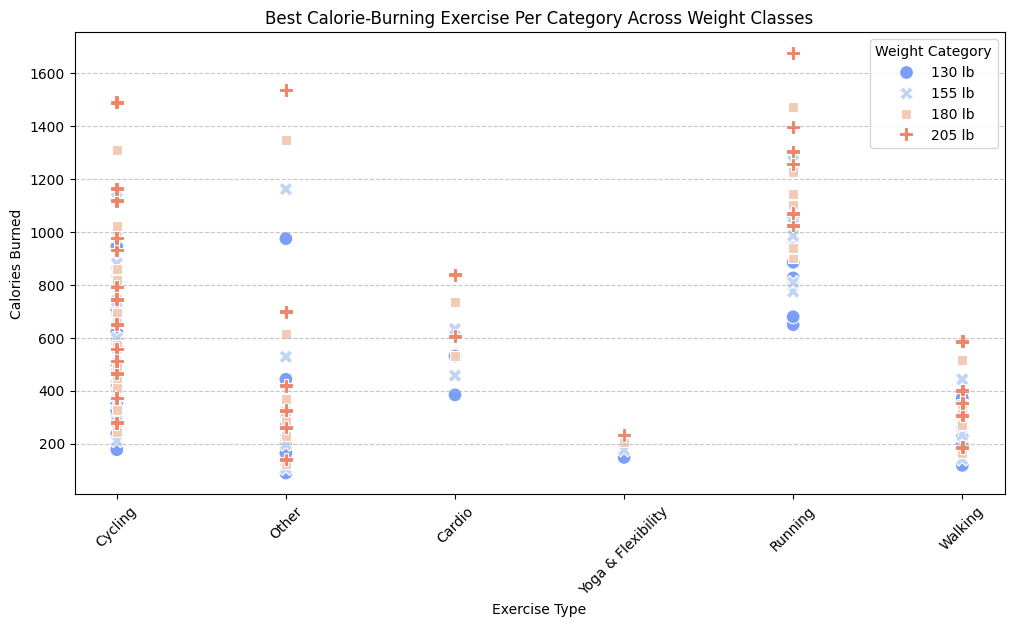

In [29]:
# Melt the DataFrame to long format
melted_df = calories_df.melt(
    id_vars=["Exercise_Category"], 
    value_vars=["130 lb", "155 lb", "180 lb", "205 lb"], 
    var_name="Weight Category", 
    value_name="Calories Burned"
)

# Plot scatterplot for all weight classes
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=melted_df["Exercise_Category"], 
    y=melted_df["Calories Burned"], 
    hue=melted_df["Weight Category"], 
    style=melted_df["Weight Category"], 
    palette="coolwarm", 
    s=100
)

# Customize the plot
plt.title("Best Calorie-Burning Exercise Per Category Across Weight Classes")
plt.xlabel("Exercise Type")
plt.ylabel("Calories Burned")
plt.xticks(rotation=45)
plt.legend(title="Weight Category")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()


Conclusions & Summary

Key Findings:

✅ Calorie Burn Varies by Exercise Type

* The highest calorie-burning exercises are:
    * Running at 10.9 mph (5.5 min mile)
    * Cross-Country Skiing (Uphill)
    * Cycling at >20 mph

* The lowest calorie-burning exercises include:
    * Mild Stretching
    * Walking (very slow)
    * Stationary Cycling (very light)

✅ Impact of Weight on Calorie Burn

* Calorie burn increases as weight increases across all activities.
* Percentage increase from 130 lb to 205 lb is highest for:
    * Running
    * Stair Climbing
    * Cycling (High Speed)

✅ Most & Least Efficient Exercises

* Most Efficient exercises for burning calories (highest Calories per kg):
    * Running (10.9 mph)
    * Cross-country skiing
    * Cycling (high intensity)
    
* Least Efficient exercises (lowest Calories per kg):
    * Mild stretching
    * Golf (walking)
    * Light household activities

✅ Exercise Variability & Predictability

* High-Variability Exercises (inconsistent calorie burn):
    * Running
    * High-speed cycling
    * Stair climbing
* Low-Variability Exercises (predictable calorie burn):
    * Mild stretching
    * Golf
    * Walking (steady pace)

Conclusion:

This analysis provides data-driven insights into how different exercises impact calorie burn across body weight classes.

🏃 Running, Cycling, and High-Intensity Workouts are best for maximum calorie expenditure

🧘 Yoga, Walking, and Light Activities provide consistent, predictable burns for flexibility & stress relief.

By understanding efficiency, variability, and calorie burn trends, individuals can customize workouts for:

    ✅ Weight loss

    ✅ Strength training

    ✅ Cardio health

    ✅ General fitness

This study helps individuals optimize their fitness routines based on personal goals, body weight, and exercise preferences.